Correlations and tryout models
==

## Libraries

In [1]:
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import overpy
import geojsonio as gjs
import json
import ipyleaflet as ipy
import osmnx as ox
import seaborn as sns
from shapely.geometry import Point, LineString, Polygon 
from descartes import PolygonPatch 
from IPython.display import IFrame 
import pysal as ps
from pysal import weights, examples
from pysal.weights import Queen

/Users/peterbruins/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
ox.config(log_console=True, use_cache=True)

### Queen matrix and spacial weights

In [3]:
geo = gpd.read_file('../Datasets/ultimate_move_df.shp')
queen_w = Queen.from_shapefile("../Datasets/ultimate_move_df.shp")

/Users/peterbruins/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 9 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/peterbruins/anaconda3/lib/python3.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 26, 122, 485, 761, 870, 1049, 1106, 1151, 1811
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


#### Identifying Unusual Block Groups Based on Neighbor Counts

Now that the adjacency matrix is built, we can examine some characteristics of the links formed. Below we plot a histogram of the number of neighbors. As you can see, the median number of neighbors for these units is somewhere around 50. Two oddities that we can see here are that there is one block group with 0 neighbors and one block group with 175(!) neighbors. We examine these further below.

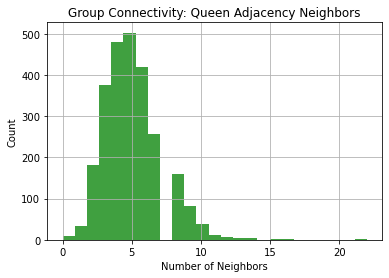

In [4]:
n, bins, patches = plt.hist(queen_w.cardinalities.values(), 25, facecolor='green', alpha=0.75)

plt.xlabel('Number of Neighbors')
plt.ylabel('Count')
plt.title('Group Connectivity: Queen Adjacency Neighbors')
plt.grid(True)

We can easily identify the “island” block group by selecting for the block group with 0 neighbors. Given that this is not a typical area within Spain, we will drop it from the analysis. However, in general, areas with no neighbors could still be included in a spatial regression model, although they would receive no spatial weight and therefore would be defined as having no relationship to any other geographic units.

From the histogram you can also see that there is a huge outlier - a block group that has 175 neighbors. We plot it below.

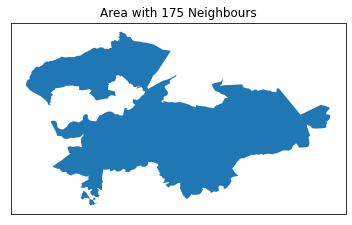

In [5]:
idmax=pd.Series(queen_w.cardinalities).idxmax()
p=geo.loc[[idmax]].plot()
s=p.set_xticks([])
s=p.set_yticks([])
title=plt.title('Area with 175 Neighbours')

#### From now on we work with data without islands

In [6]:
islands = queen_w.islands
geo=geo[~geo.index.isin(islands)]

#### Exporting cleaned file

In [7]:
geo.to_file("../Datasets/ultimate_move_df_cleaned.shp")

### New Dataset

We do some feature engineering to reduce the noise of the features.

In [8]:
geo = gpd.read_file('../Datasets/ultimate_move_df_cleaned.shp')

In [13]:
df_tryout = geo.copy(deep=True)
df_tryout['tot_build_perc'] = df_tryout.srf_tot/df_tryout.shape__are
df_tryout['housing_perc'] = df_tryout.srf_housin/df_tryout.shape__are

df_tryout['shape__are'] = df_tryout.shape__are /1000000
df_tryout['pop_per_km2'] = df_tryout.tot_pop/df_tryout.shape__are
df_tryout['male_female_ratio'] = df_tryout.Male/df_tryout.Female
df_tryout['young_per_km2'] = df_tryout.sub_16_age / df_tryout.shape__are
df_tryout['middle_per_km2'] = df_tryout['16_to_64_a'] / df_tryout.shape__are
df_tryout['old_per_km2'] = df_tryout['64_more_ag'] / df_tryout.shape__are
df_tryout['travel_perc'] = df_tryout.pob_sale/df_tryout.tot_pop
df_tryout['stay_home_perc'] = df_tryout.pob_casa/df_tryout.tot_pop

df_tryout = df_tryout.drop(['shape_leng','shape_leng','NO2_avg_ut'
                           ,'sub_16_age','16_to_64_a','64_more_ag','weight_urb','weight_tr','Male',
                            'Female','srf_housin','srf_tot'], axis = 1)

#### Exporting file

In [16]:
geoda_tryout = gpd.GeoDataFrame(df_tryout, crs="EPSG:4326", geometry='geometry')
geoda_tryout.to_file('../Datasets/geoda_tryout.geojson', driver='GeoJSON')

## Correlation and Feature selection with the New Dataset

In [17]:
df_tryout = gpd.read_file('../Datasets/geoda_tryout.geojson')
df_tryout = df_tryout.drop(['name_celda','shape__len','O3_p932','O3_SOMO35','O3_S10','tot_pop'],axis=1)

### Correlations

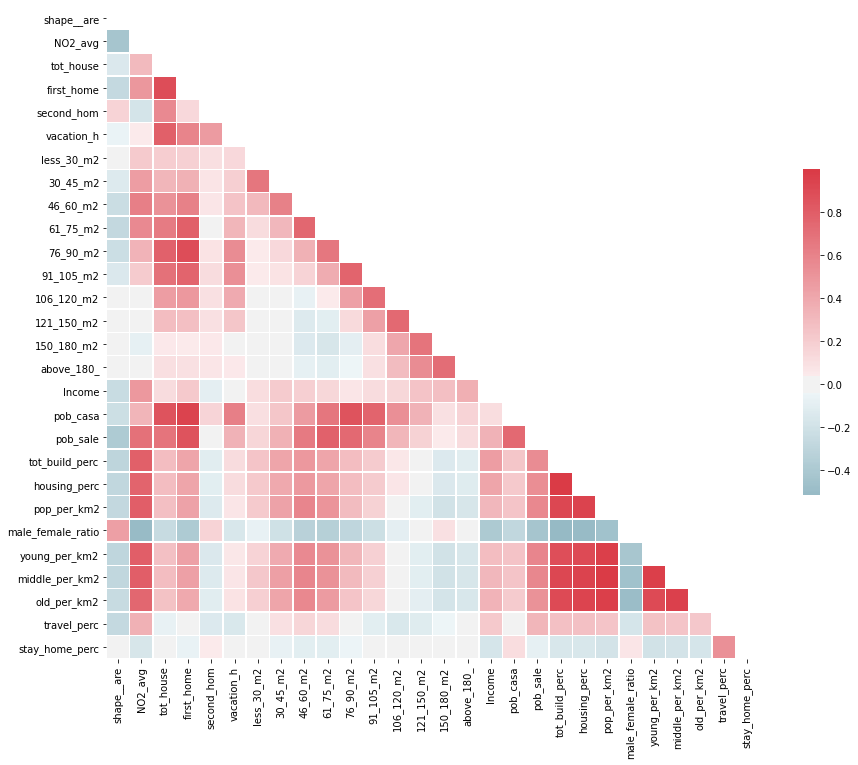

In [18]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(16, 12))

import seaborn as sns
mask = np.zeros_like(df_tryout.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_tryout.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Random Forest Regressor

In [19]:
X = df_tryout.drop(['NO2_avg','geometry','pop_per_km2','shape__are'],axis=1)
col_names = X.columns.tolist()
X = X.values
NO2_avg = df_tryout.NO2_avg
np.set_printoptions(suppress=True)

#### Create DataFrames for plotting

In [21]:
resall=pd.DataFrame()
res_w1=pd.DataFrame()

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

seed=7

kfold=KFold(n_splits=10, random_state=seed, shuffle = True)

num_trees=100
num_features=5
max_depth = 5
model=RandomForestRegressor(n_estimators=num_trees, max_features=num_features,max_depth=max_depth, random_state=seed)
model.fit(X,NO2_avg)

results_NO2_avg=cross_val_score(model, X, NO2_avg, cv=kfold)

print(f'Random Forest - Accuracy {results_NO2_avg.mean()*100:.3f}% std {results_NO2_avg.std()*100:3f}%')

res_w1["Res"]=results_NO2_avg
res_w1["Type"]="Random Forest"

resall=pd.concat([resall,res_w1], ignore_index=True)

Random Forest - Accuracy 85.746% std 0.444071%


In [23]:
mean_NO2_avg = NO2_avg.mean()
print(f'Average NO2 level: {mean_NO2_avg}')
print()
print(f'Expected error range: [{mean_NO2_avg-(1-results_NO2_avg.mean()/100)}, {mean_NO2_avg+(1-results_NO2_avg.mean()/100)}]')

Average NO2 level: 12.847696532150087

Expected error range: [11.856271169278983, 13.83912189502119]


tot_house        0.0022
first_home       0.0141
second_hom       0.0102
vacation_h       0.0046
less_30_m2       0.0039
30_45_m2         0.0217
46_60_m2         0.0503
61_75_m2         0.0218
76_90_m2         0.0039
91_105_m2        0.0014
106_120_m2       0.0012
121_150_m2       0.0015
150_180_m2       0.0016
above_180_       0.0021
Income           0.0138
pob_casa         0.0030
pob_sale         0.0311
tot_build_perc   0.1526
housing_perc     0.1124
male_female_ratio  0.0091
young_per_km2    0.1817
middle_per_km2   0.1832
old_per_km2      0.1438
travel_perc      0.0277
stay_home_perc   0.0011


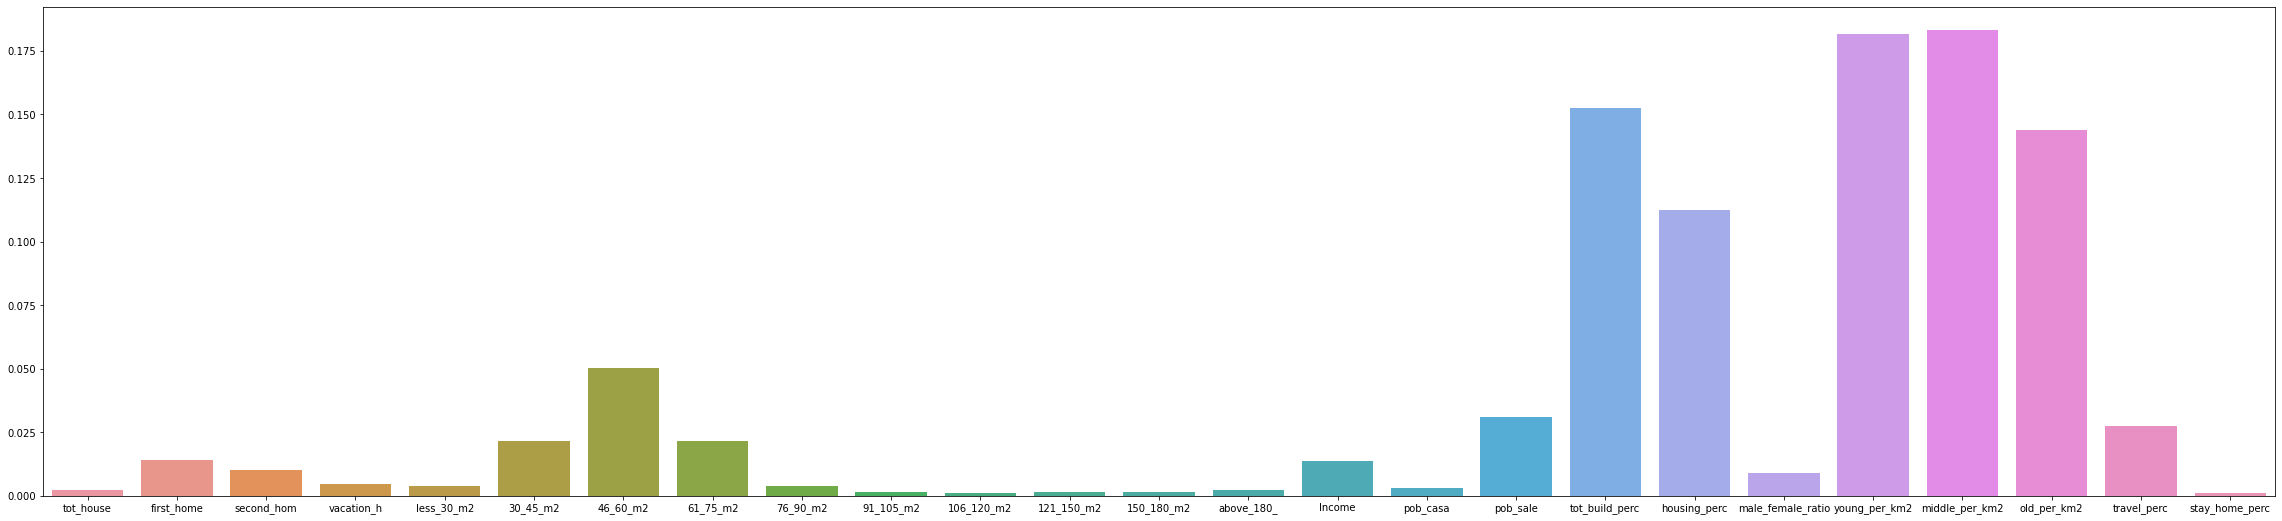

In [24]:
plt.figure(figsize=(40,9))

for name, importance in zip(col_names, model.feature_importances_):
    print(f'{name:15s}  {importance:.4f}')

sns.barplot(x=col_names, y=model.feature_importances_, order=col_names)

## Correlation and Feature selection with the Adjusted Dataset

We bin the building features.

In [25]:
df_tryout['less45m2_per_km2'] = (df_tryout['less_30_m2'] + df_tryout['30_45_m2'])/df_tryout.shape__are
df_tryout['46m2_50m2_per_km2']=df_tryout['46_60_m2']/df_tryout.shape__are
df_tryout['61m2_90m2_per_km2'] = (df_tryout['61_75_m2'] + df_tryout['76_90_m2'] )/df_tryout.shape__are
df_tryout['more90m2_per_km2'] = ( df_tryout['91_105_m2']+df_tryout['106_120_m2'] +  df_tryout['121_150_m2'] + df_tryout['150_180_m2'] + df_tryout['above_180_'])/df_tryout.shape__are


df_tryout = df_tryout.drop(['less_30_m2' ,'30_45_m2','46_60_m2', '61_75_m2','76_90_m2','91_105_m2','106_120_m2','121_150_m2','150_180_m2',
                            'above_180_','first_home', 'pop_per_km2','tot_house','stay_home_perc','pob_casa','male_female_ratio','second_hom','vacation_h'], axis = 1)

In [26]:
df_tryout.to_file('../Datasets/final_models&corr.geojson', driver='GeoJSON')
df_tryout.to_file('../Datasets/final_models&corr.shp')

### Correlation

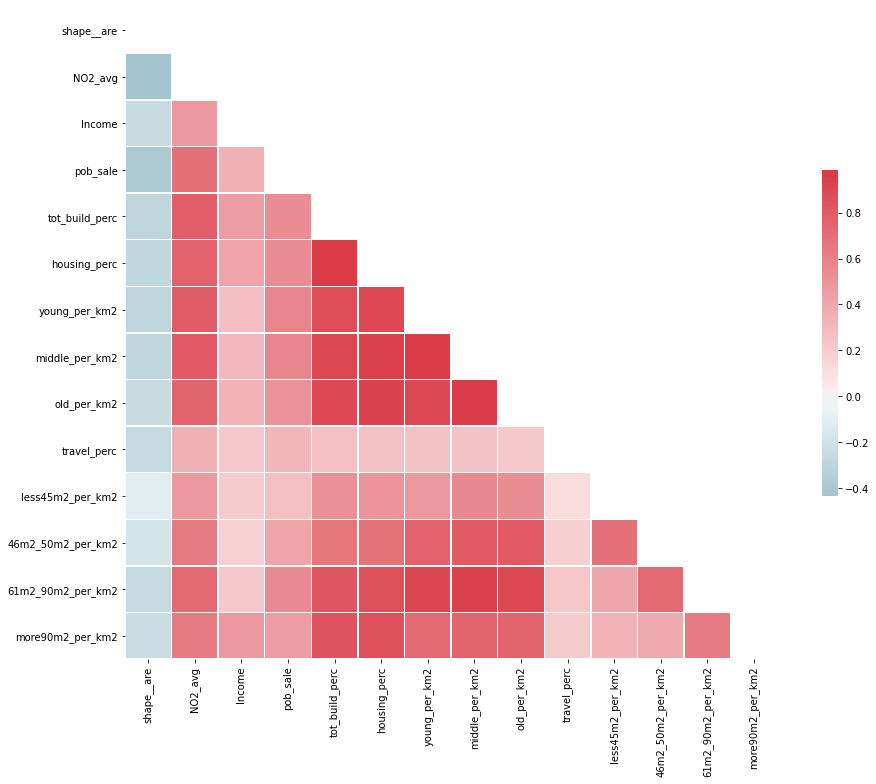

In [27]:
f, ax = plt.subplots(figsize=(16, 12))

mask = np.zeros_like(df_tryout.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_tryout.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [28]:
X = df_tryout.drop(['NO2_avg','geometry','shape__are'],axis=1)
col_names = X.columns.tolist()
X = X.values
NO2_avg = df_tryout.NO2_avg
np.set_printoptions(suppress=True)

#### Create the DataFrames for plotting

In [29]:
resall=pd.DataFrame()
res_w1=pd.DataFrame()

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

seed=7

kfold=KFold(n_splits=10, random_state=seed, shuffle = True)

num_trees=100
num_features=5
max_depth = 5
model=RandomForestRegressor(n_estimators=num_trees, max_features=num_features,max_depth=max_depth, random_state=seed)
model.fit(X,NO2_avg)

results_NO2_avg=cross_val_score(model, X, NO2_avg, cv=kfold)

print(f'Random Forest - Accuracy {results_NO2_avg.mean()*100:.3f}% std {results_NO2_avg.std()*100:3f}%')

res_w1["Res"]=results_NO2_avg
res_w1["Type"]="Random Forest"

resall=pd.concat([resall,res_w1], ignore_index=True)

Random Forest - Accuracy 85.866% std 0.732558%


In [31]:
mean_NO2_avg = NO2_avg.mean()
print(f'Average NO2 level: {mean_NO2_avg}')
print()
print(f'Expected error range: [{mean_NO2_avg-(1-results_NO2_avg.mean()/100)}, {mean_NO2_avg+(1-results_NO2_avg.mean()/100)}]')

Average NO2 level: 12.847696532150087

Expected error range: [11.856283154230335, 13.839109910069839]


#### Results

We can see a loss in accuracy of roughly 0.5% and a 0.1% decrease in standard deviation. Expected error range is mostly the same. Not a statistically significant result.


Income           0.0231
pob_sale         0.0083
tot_build_perc   0.1713
housing_perc     0.0486
young_per_km2    0.2829
middle_per_km2   0.2295
old_per_km2      0.0431
travel_perc      0.0078
less45m2_per_km2  0.0376
46m2_50m2_per_km2  0.0755
61m2_90m2_per_km2  0.0561
more90m2_per_km2  0.0163


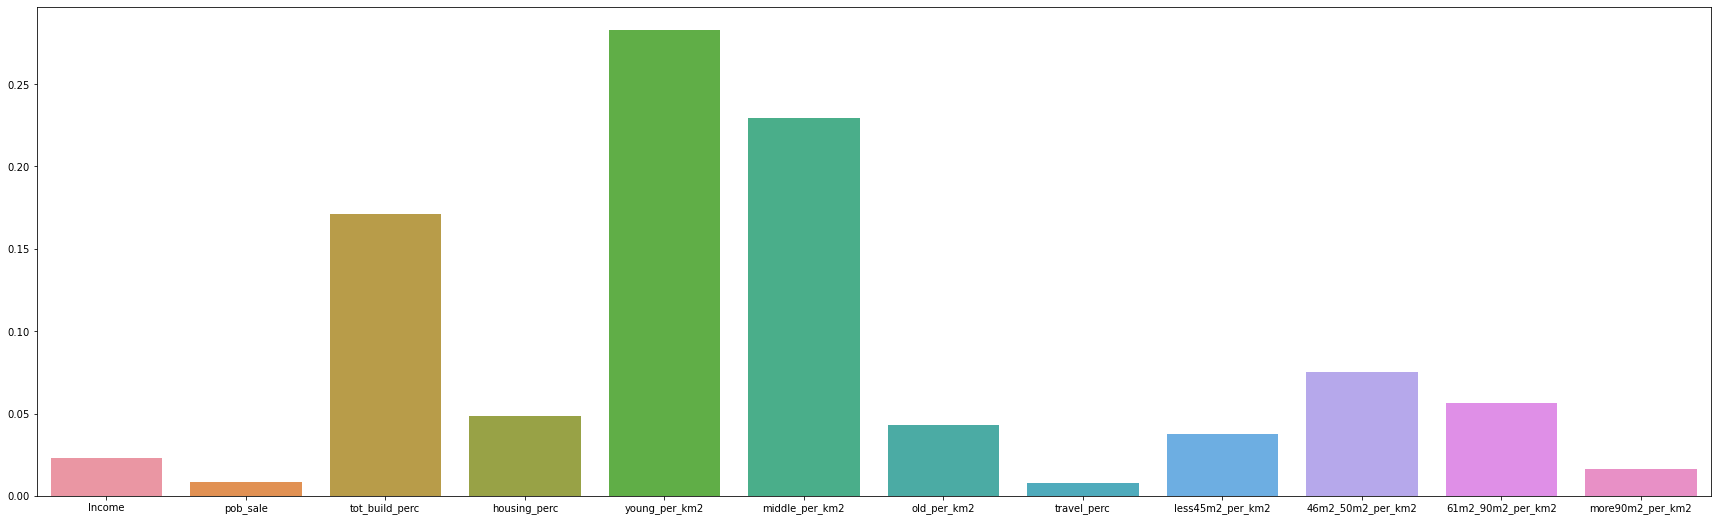

In [32]:
plt.figure(figsize=(30,9))

for name, importance in zip(col_names, model.feature_importances_):
    print(f'{name:15s}  {importance:.4f}')

sns.barplot(x=col_names, y=model.feature_importances_)

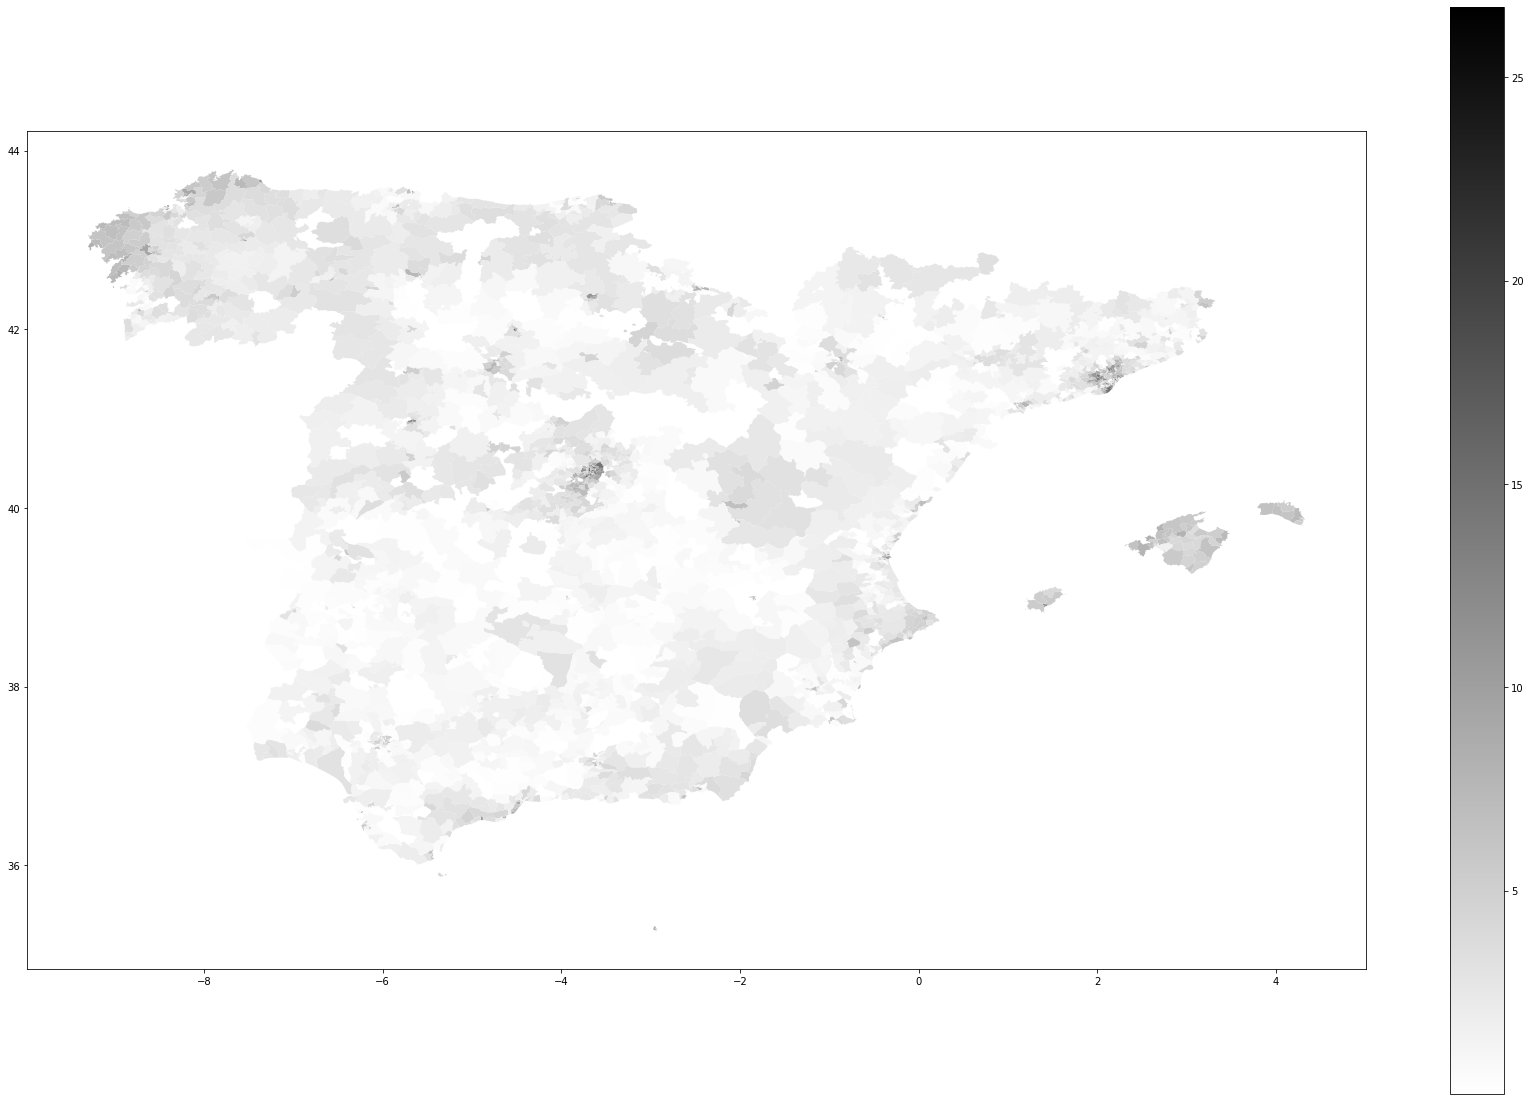

In [419]:
predict = model.predict(X)

abs_differ = abs(predict - NO2_avg)
abs_differ = pd.DataFrame(abs_differ)

abs_differ = abs_differ.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
abs_differ = gpd.GeoDataFrame(abs_differ, crs="EPSG:4326", geometry='geometry')


vmin, vmax = 0, 6
fig, ax = plt.subplots(1, figsize=(30, 20))
abs_differ.plot(column='NO2_avg', cmap='gist_yarg', linewidth=0.8,ax = ax, legend=True)

#### Results

In the previous model, total population per $ km^2 $ accounted most of the weight, followed by the youngest segment of population. The density of building per $ km^2 $ did not play a relevant role.

In the adjusted model, the results are somehow consistent, but now building density plays a major role in the prediction.

### Tweaked model 

To account for a better result, after the meeting of Sep 8 2020, we decided to add the building house density as a feature.

## Lagged spacial regression

Now we want to add very usefull but yet unused data, spacial information. First we will tryout lagged regressors with an unlagged dependend variable.

In [34]:
df = df_tryout.copy(deep=True)


#### Importing the Queen matrix

In [36]:
queen_w = Queen.from_shapefile('../Datasets/final_models&corr.shp')
queen_w.transform='r'

In [415]:
Y = df.NO2_avg
income = df.Income
pob_sale = df.pob_sale
travel_perc = df.travel_perc

tot_build_perc = df.tot_build_perc
housing_perc = df.housing_perc

young_per_km2 = df.young_per_km2
middle_per_km2 = df.middle_per_km2
old_per_km2 = df.old_per_km2

less45m2_per_km2 = df.less45m2_per_km2
med_small_per_km2 = df['46m2_50m2_per_km2']
large_med_per_km2 = df['61m2_90m2_per_km2']
more90m2_per_km2 = df.more90m2_per_km2

####################
income = np.asarray(income).reshape(-1,1).astype(float)
pob_sale = np.asarray(pob_sale).reshape(-1,1).astype(float)
travel_perc = np.asarray(travel_perc).reshape(-1,1).astype(float)

tot_build_perc = np.asarray(tot_build_perc).reshape(-1,1).astype(float)
housing_perc = np.asarray(housing_perc).reshape(-1,1).astype(float)

young_per_km2 = np.asarray(young_per_km2).reshape(-1,1).astype(float)
middle_per_km2 = np.asarray(middle_per_km2).reshape(-1,1).astype(float)
old_per_km2 = np.asarray(old_per_km2).reshape(-1,1).astype(float)

less45m2_per_km2 = np.asarray(less45m2_per_km2).reshape(-1,1).astype(float)
med_small_per_km2 = np.asarray(med_small_per_km2).reshape(-1,1).astype(float)
large_med_per_km2 = np.asarray(large_med_per_km2).reshape(-1,1).astype(float)
more90m2_per_km2 = np.asarray(more90m2_per_km2).reshape(-1,1).astype(float)

######################
y_lag = ps.weights.lag_spatial(queen_w, Y)
income_lag = ps.weights.lag_spatial(queen_w, income)
pob_sale_lag = ps.weights.lag_spatial(queen_w, pob_sale)
travel_perc_lag = ps.weights.lag_spatial(queen_w, travel_perc)

tot_build_perc_lag = ps.weights.lag_spatial(queen_w, tot_build_perc)
housing_perc_lag = ps.weights.lag_spatial(queen_w, housing_perc)

young_per_km2_lag = ps.weights.lag_spatial(queen_w, young_per_km2)
middle_per_km2_lag = ps.weights.lag_spatial(queen_w, middle_per_km2)
old_per_km2_lag = ps.weights.lag_spatial(queen_w, old_per_km2)

less45m2_per_km2_lag = ps.weights.lag_spatial(queen_w, less45m2_per_km2)
med_small_per_km2_lag = ps.weights.lag_spatial(queen_w, med_small_per_km2)
large_med_per_km2_lag = ps.weights.lag_spatial(queen_w, large_med_per_km2)
more90m2_per_km2_lag = ps.weights.lag_spatial(queen_w, more90m2_per_km2)



lag_matrix = np.concatenate(( income_lag,  pob_sale_lag,travel_perc_lag, tot_build_perc_lag, housing_perc_lag, young_per_km2_lag, middle_per_km2_lag, old_per_km2_lag, less45m2_per_km2_lag, med_small_per_km2_lag, large_med_per_km2_lag,more90m2_per_km2_lag),axis=1)
names= ['income_lag','pob_sale_lag','travel_perc_lag','tot_build_perc_lag','housing_perc_lag','young_per_km2_lag','middle_per_km2_lag','old_per_km2_lag','less45m2_per_km2_lag','med_small_per_km2_lag','large_med_per_km2_lag','more90m2_per_km2_lag']

lag_df = pd.DataFrame(data=lag_matrix, columns= names, index = None )
lag_df.head()

,income_lag,pob_sale_lag,travel_perc_lag,tot_build_perc_lag,housing_perc_lag,young_per_km2_lag,middle_per_km2_lag,old_per_km2_lag,less45m2_per_km2_lag,med_small_per_km2_lag,large_med_per_km2_lag,more90m2_per_km2_lag
0,8049.013547,2152.833333,0.199463,0.019723,0.010799,18.371270,68.863829,18.055824,0.151735,0.837284,13.074182,20.960332
1,9151.277970,3057.000000,0.221474,0.016318,0.007816,15.028485,50.776721,9.051079,0.153545,0.496147,9.962057,8.316135
2,11020.721722,3237.666667,0.284120,0.043781,0.026579,36.338145,170.389794,48.901862,0.625001,5.547720,35.730486,30.383393
3,9129.130428,1617.416667,0.227910,0.004075,0.002256,2.235243,9.863729,3.518146,0.022772,0.103536,1.729615,3.209079
4,13079.713108,4625.000000,0.323486,0.100756,0.051589,153.415612,502.060415,99.827321,2.161939,20.805109,149.579808,80.842247


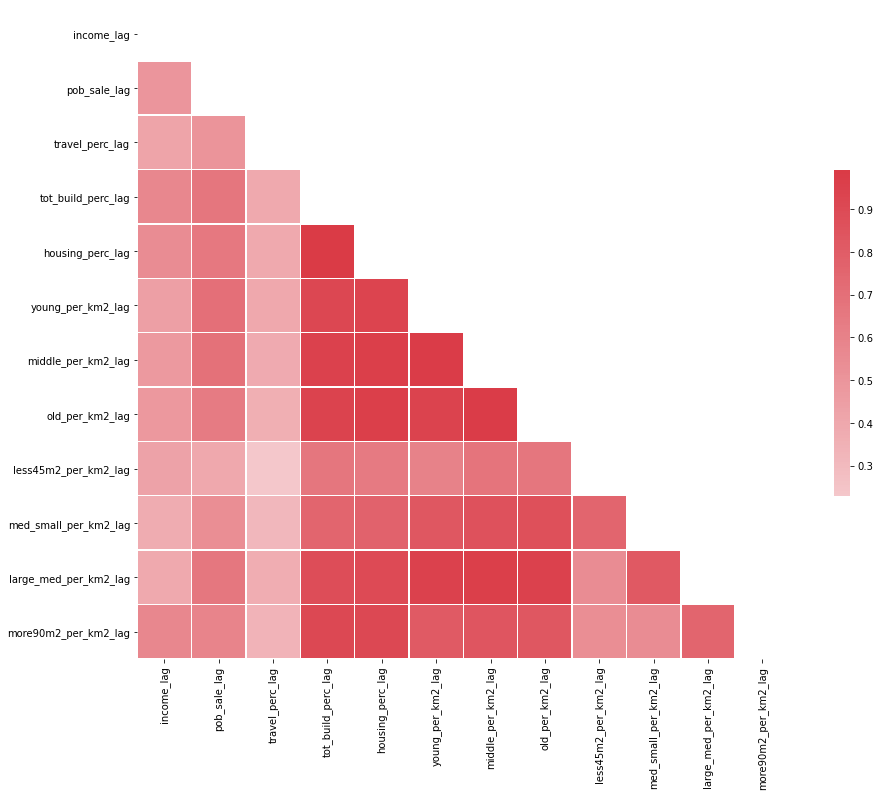

In [416]:
lag_matrix1= pd.DataFrame(lag_matrix)
lag_matrix1.columns = names
f, ax = plt.subplots(figsize=(16, 12))

mask = np.zeros_like(lag_matrix1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lag_matrix1.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Spacial auto correlations (Moran I) of features:<br/>

NO2_avg 0.90<br/>

Income 0.72<br/>
pob_sale 0.62<br/>
travel_perc 0.28<br/>

tot_build_perc 0.68<br/>
housing_perc 0.63<br/>

you_per 0.60<br/>
middle_per 0.63<br/>
old_per 0.62<br/>

small_house 0.50<br/>
med_small_per_km2 0.57<br/>
large_med_per_km2 0.58<br/>
large_house 0.56



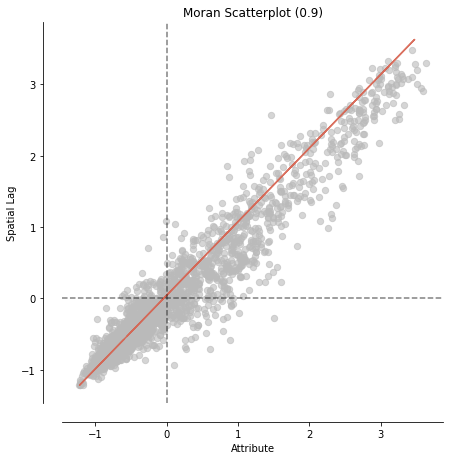

In [418]:
from esda.moran import Moran
moran_Y  = Moran(Y , queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_Y , aspect_equal=True)
plt.show()

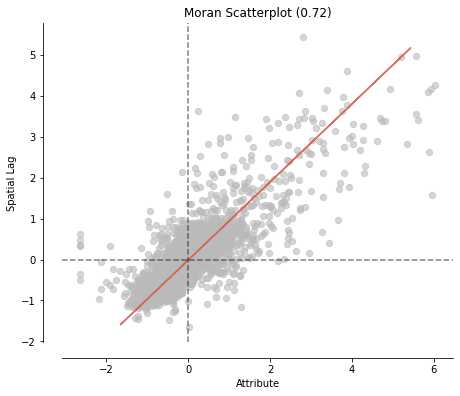

In [80]:
from esda.moran import Moran
moran_inc = Moran(income, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_inc, aspect_equal=True)
plt.show()


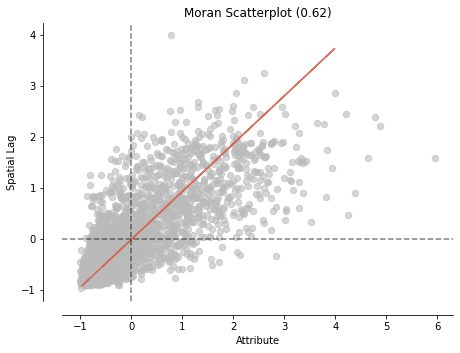

In [83]:
from esda.moran import Moran
moran_pob_sale = Moran(pob_sale, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_pob_sale, aspect_equal=True)
plt.show()

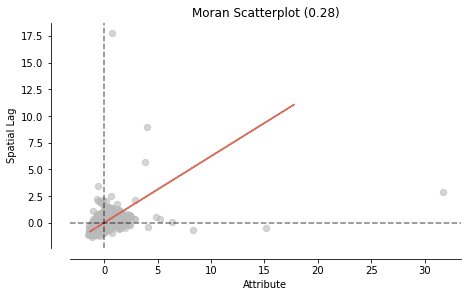

In [84]:
from esda.moran import Moran
moran_travel_perc = Moran(travel_perc, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_travel_perc, aspect_equal=True)
plt.show()

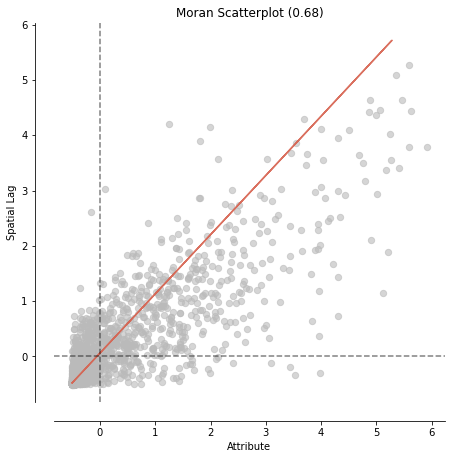

In [85]:
from esda.moran import Moran
moran_tot_build_perc = Moran(tot_build_perc, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_tot_build_perc, aspect_equal=True)
plt.show()

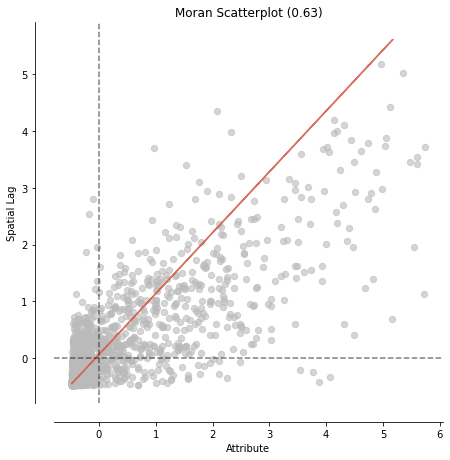

In [86]:
from esda.moran import Moran
moran_housing_perc = Moran(housing_perc, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_housing_perc, aspect_equal=True)
plt.show()

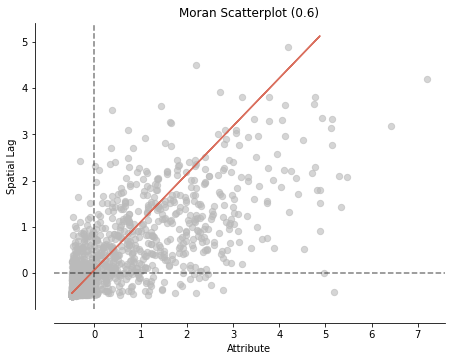

In [87]:
from esda.moran import Moran
moran_young_per_km2 = Moran(young_per_km2, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_young_per_km2, aspect_equal=True)
plt.show()

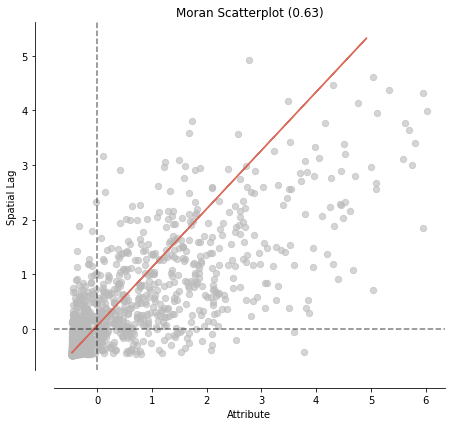

In [88]:
from esda.moran import Moran
moran_middle_per_km2 = Moran(middle_per_km2, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_middle_per_km2, aspect_equal=True)
plt.show()

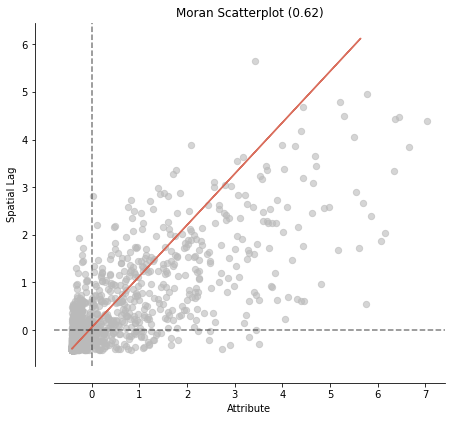

In [89]:
from esda.moran import Moran
moran_old_per_km2 = Moran(old_per_km2, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_old_per_km2, aspect_equal=True)
plt.show()

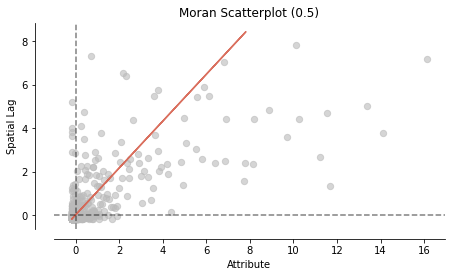

In [90]:
from esda.moran import Moran
moran_less45m2_per_km2 = Moran(less45m2_per_km2, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_less45m2_per_km2, aspect_equal=True)
plt.show()

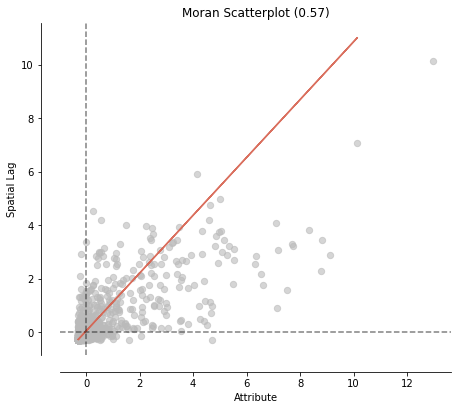

In [91]:
from esda.moran import Moran
moran_med_small_per_km2 = Moran(med_small_per_km2, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_med_small_per_km2, aspect_equal=True)
plt.show()

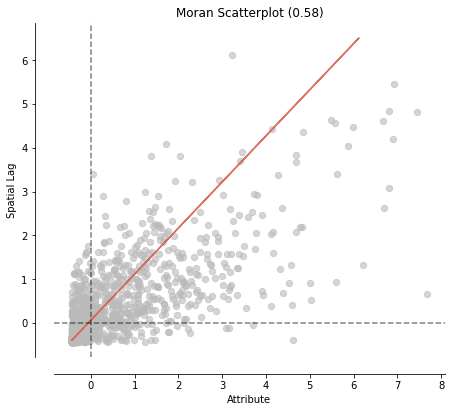

In [92]:
from esda.moran import Moran
moran_large_med_per_km2 = Moran(large_med_per_km2, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_large_med_per_km2, aspect_equal=True)
plt.show()

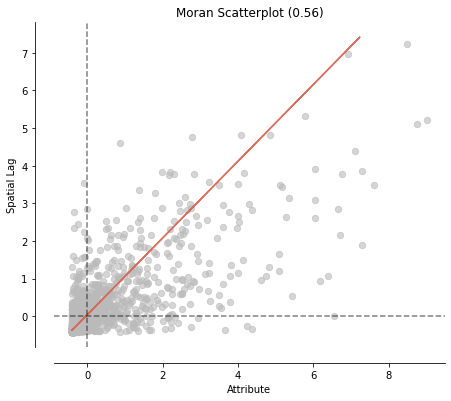

In [93]:
from esda.moran import Moran
moran_more90m2_per_km2 = Moran(more90m2_per_km2, queen_w)
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran_more90m2_per_km2, aspect_equal=True)
plt.show()

### Maps of the features

#### Income_lag

In [38]:
income_lag1 = pd.DataFrame(income_lag)
income_lag1 = income_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
income_lag1 = gpd.GeoDataFrame(income_lag1, crs="EPSG:4326", geometry='geometry')
income_lag1

,0,geometry
0,8049.013547,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,9151.277970,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,11020.721722,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,9129.130428,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,13079.713108,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,11245.455630,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,10416.827571,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,9978.648525,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,8060.425312,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


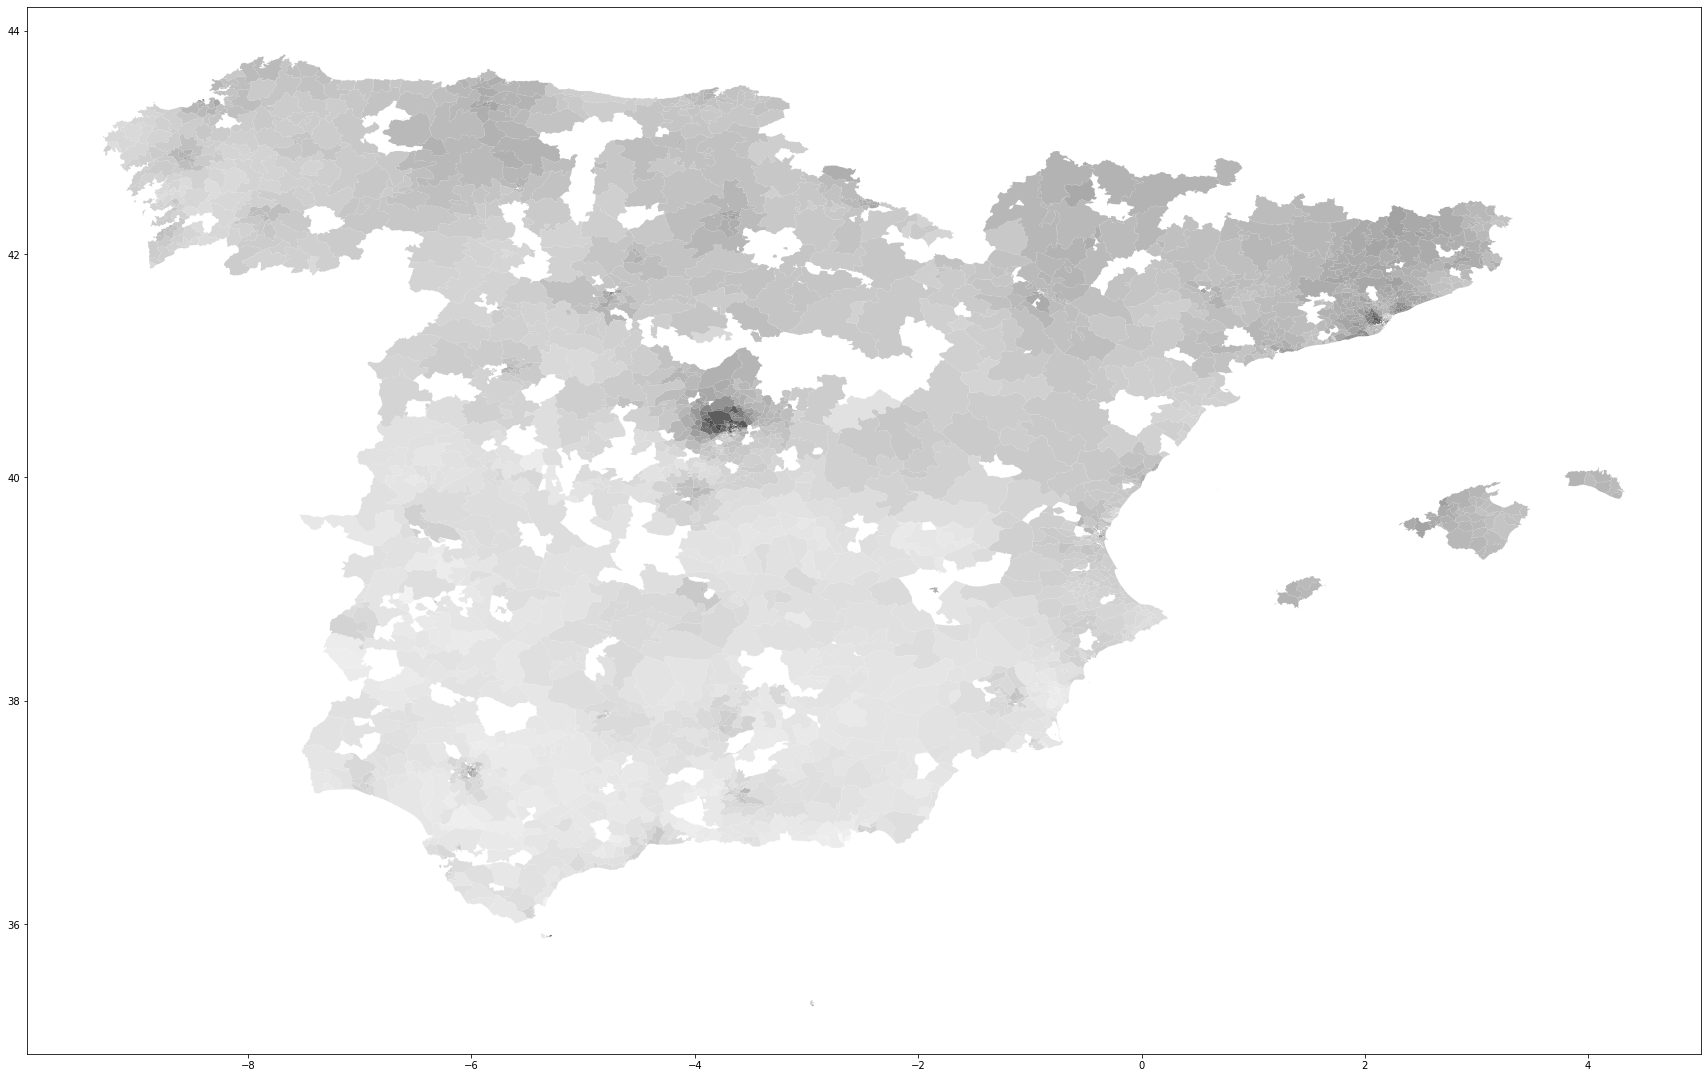

In [39]:
vmin, vmax = 3000, 12000

fig, ax = plt.subplots(1, figsize=(30, 20))

income_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### pob_sale_lag

In [40]:
pob_sale_lag1 = pd.DataFrame(pob_sale_lag)
pob_sale_lag1 = pob_sale_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
pob_sale_lag1 = gpd.GeoDataFrame(pob_sale_lag1, crs="EPSG:4326", geometry='geometry')
pob_sale_lag1

,0,geometry
0,2152.833333,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,3057.000000,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,3237.666667,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,1617.416667,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,4625.000000,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,3182.857143,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,1064.000000,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,1455.750000,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,1248.666667,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


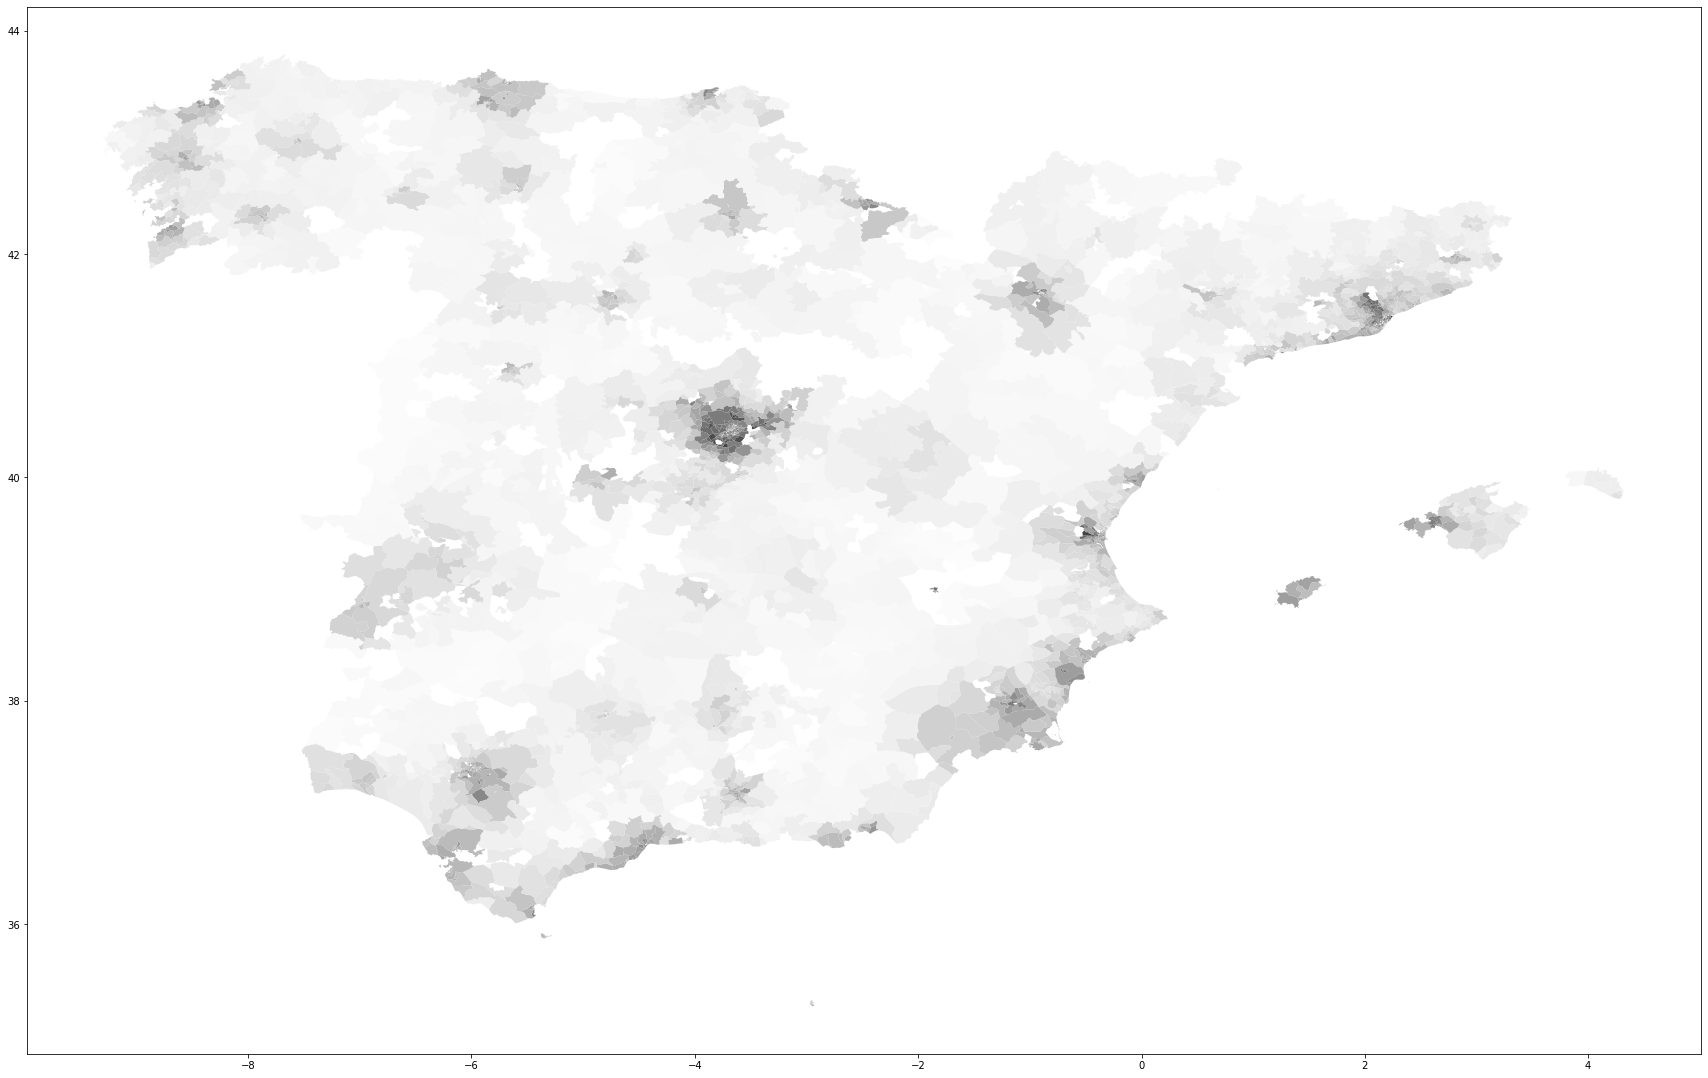

In [41]:
vmin, vmax = 3000, 16000

fig, ax = plt.subplots(1, figsize=(30, 20))

pob_sale_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

####  tot_build_perc_lag

In [42]:
tot_build_perc_lag1 = pd.DataFrame(tot_build_perc_lag)
tot_build_perc_lag1 = tot_build_perc_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
tot_build_perc_lag1 = gpd.GeoDataFrame(tot_build_perc_lag1, crs="EPSG:4326", geometry='geometry')
tot_build_perc_lag1

,0,geometry
0,0.019723,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,0.016318,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,0.043781,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,0.004075,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,0.100756,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,0.017714,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,0.004439,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,0.003759,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,0.005449,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


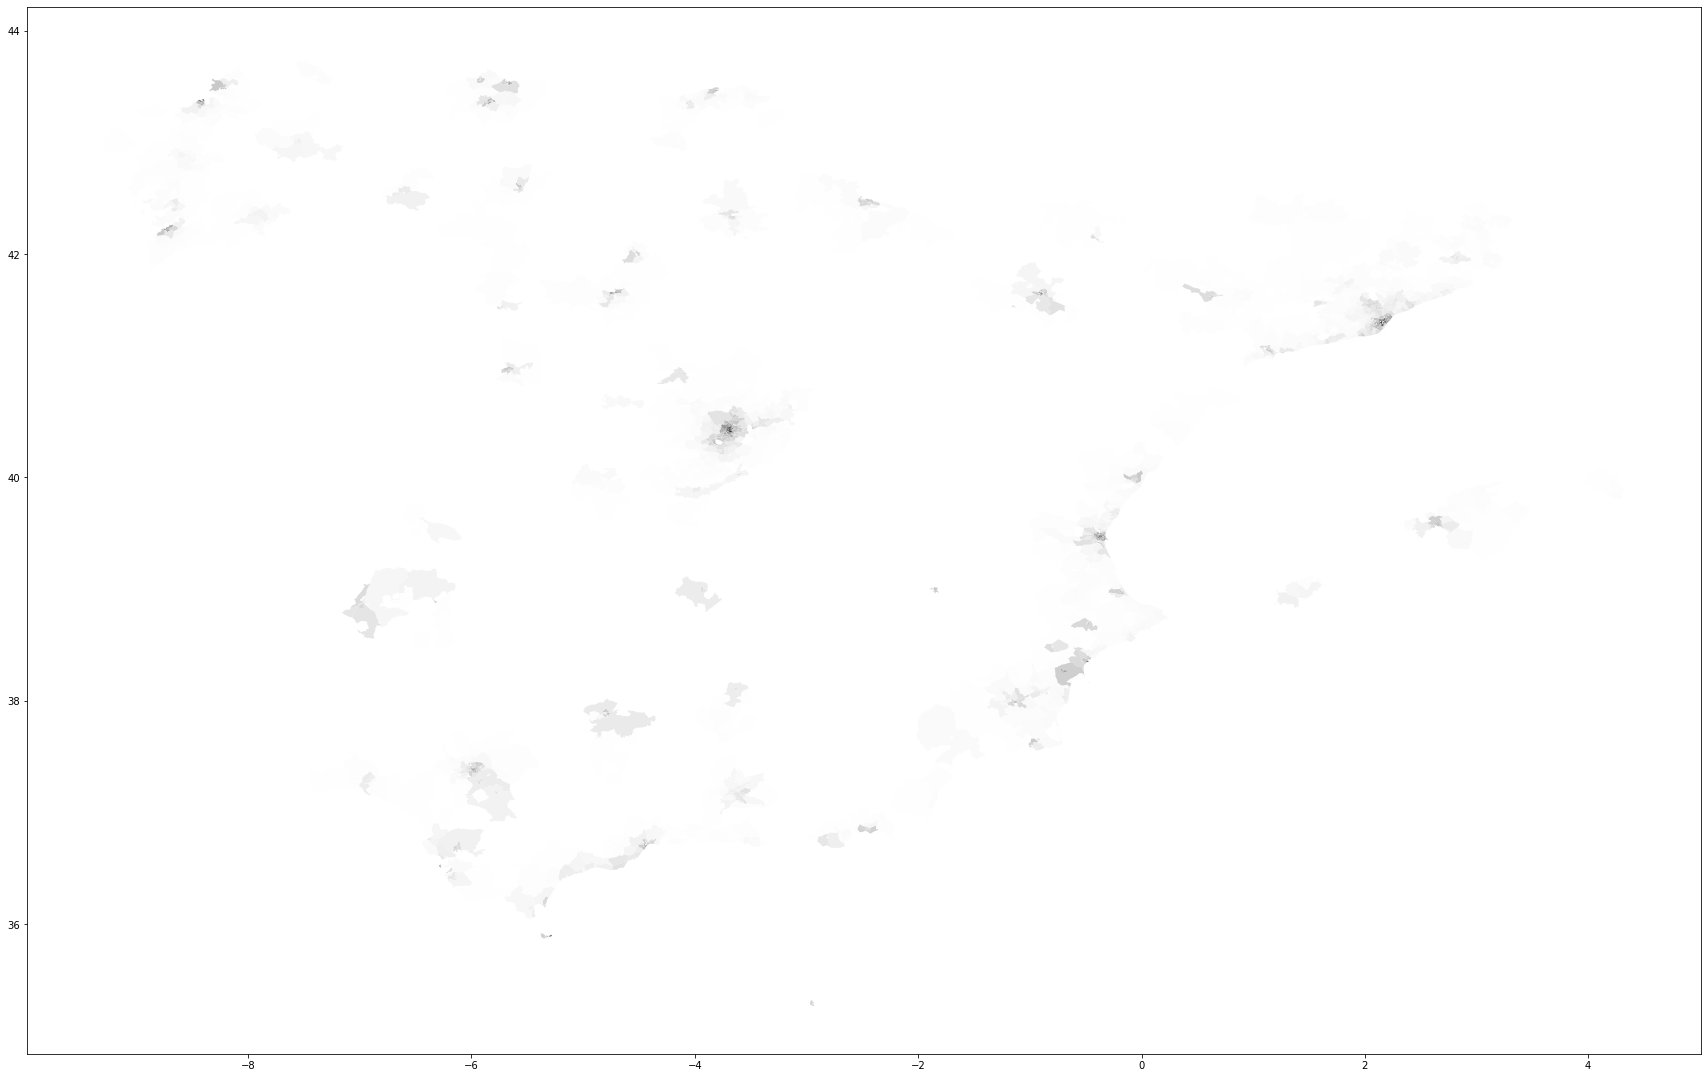

In [43]:
vmin, vmax = 0.0, 1.5

fig, ax = plt.subplots(1, figsize=(30, 20))

tot_build_perc_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### housing_perc_lag

In [44]:
housing_perc_lag1 = pd.DataFrame(housing_perc_lag)
housing_perc_lag1 = housing_perc_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
housing_perc_lag1 = gpd.GeoDataFrame(housing_perc_lag1, crs="EPSG:4326", geometry='geometry')
housing_perc_lag1

,0,geometry
0,0.010799,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,0.007816,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,0.026579,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,0.002256,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,0.051589,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,0.010677,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,0.001998,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,0.002095,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,0.003587,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


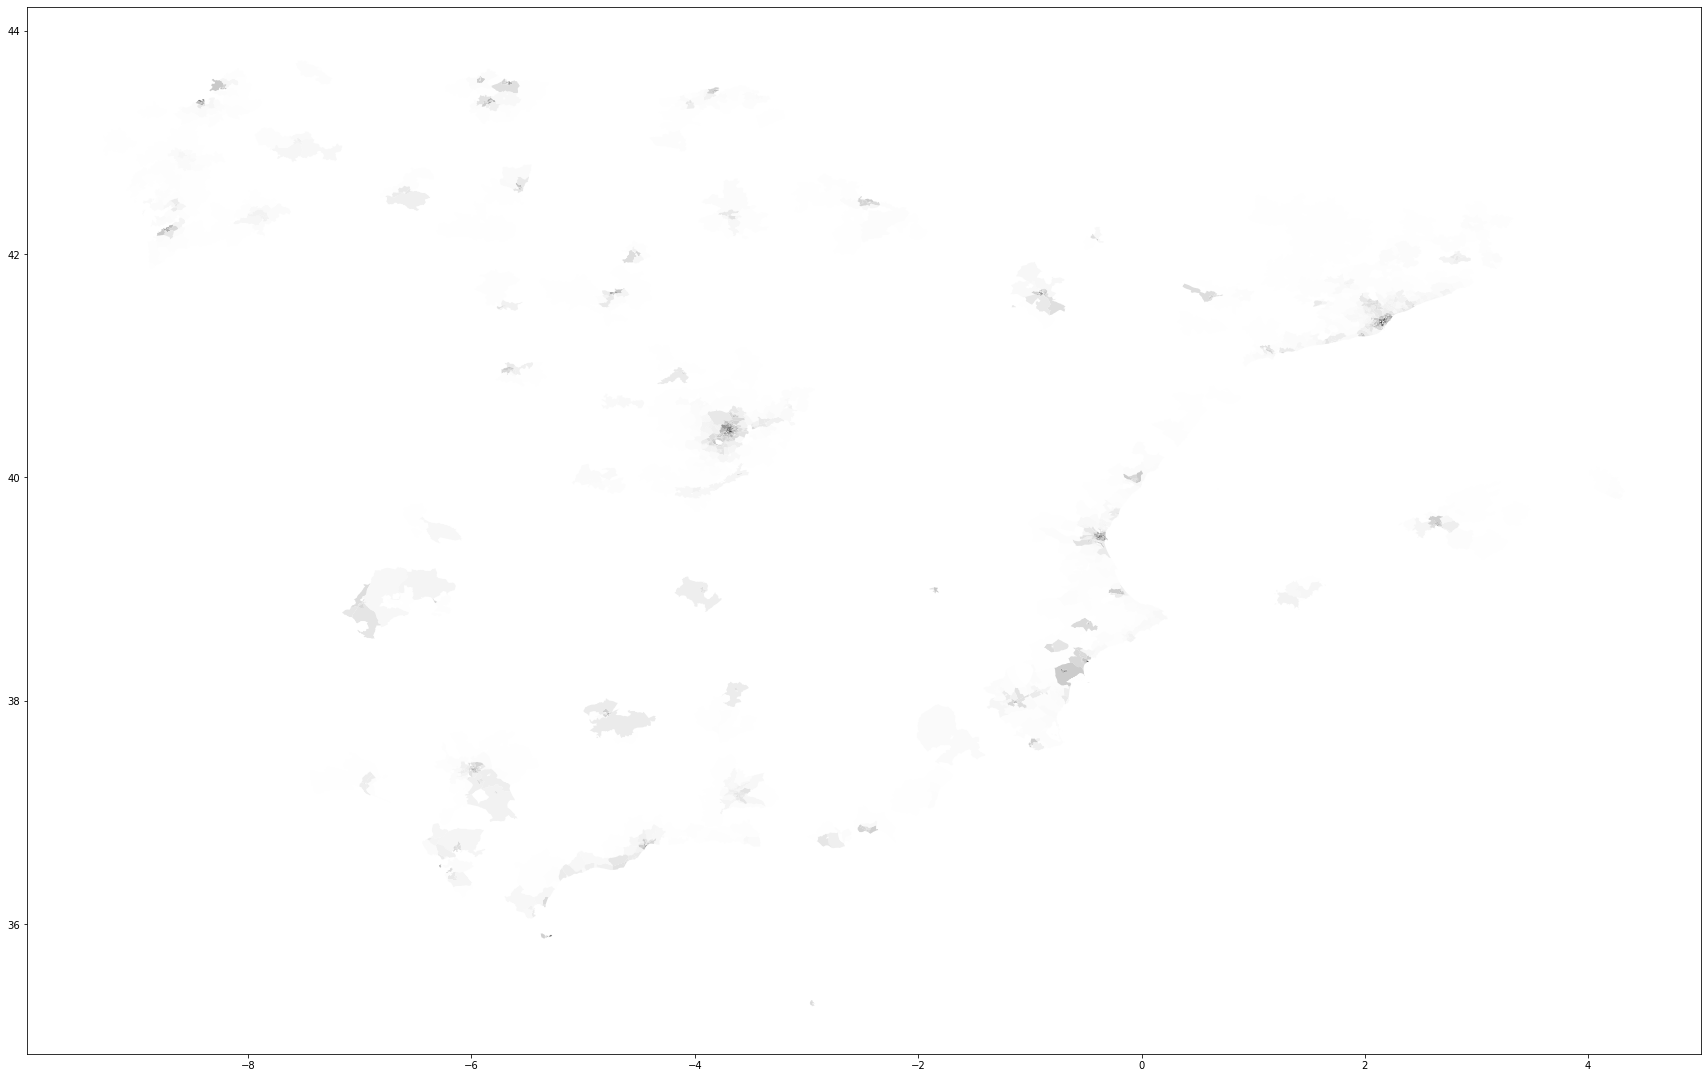

In [45]:
vmin, vmax = 0.0, 1

fig, ax = plt.subplots(1, figsize=(30, 20))

housing_perc_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### young_per_km2_lag

In [46]:
young_per_km2_lag1 = pd.DataFrame(young_per_km2_lag)
young_per_km2_lag1 = young_per_km2_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
young_per_km2_lag1 = gpd.GeoDataFrame(young_per_km2_lag1, crs="EPSG:4326", geometry='geometry')
young_per_km2_lag1

,0,geometry
0,18.371270,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,15.028485,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,36.338145,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,2.235243,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,153.415612,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,15.112483,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,1.343087,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,1.848262,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,3.414878,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


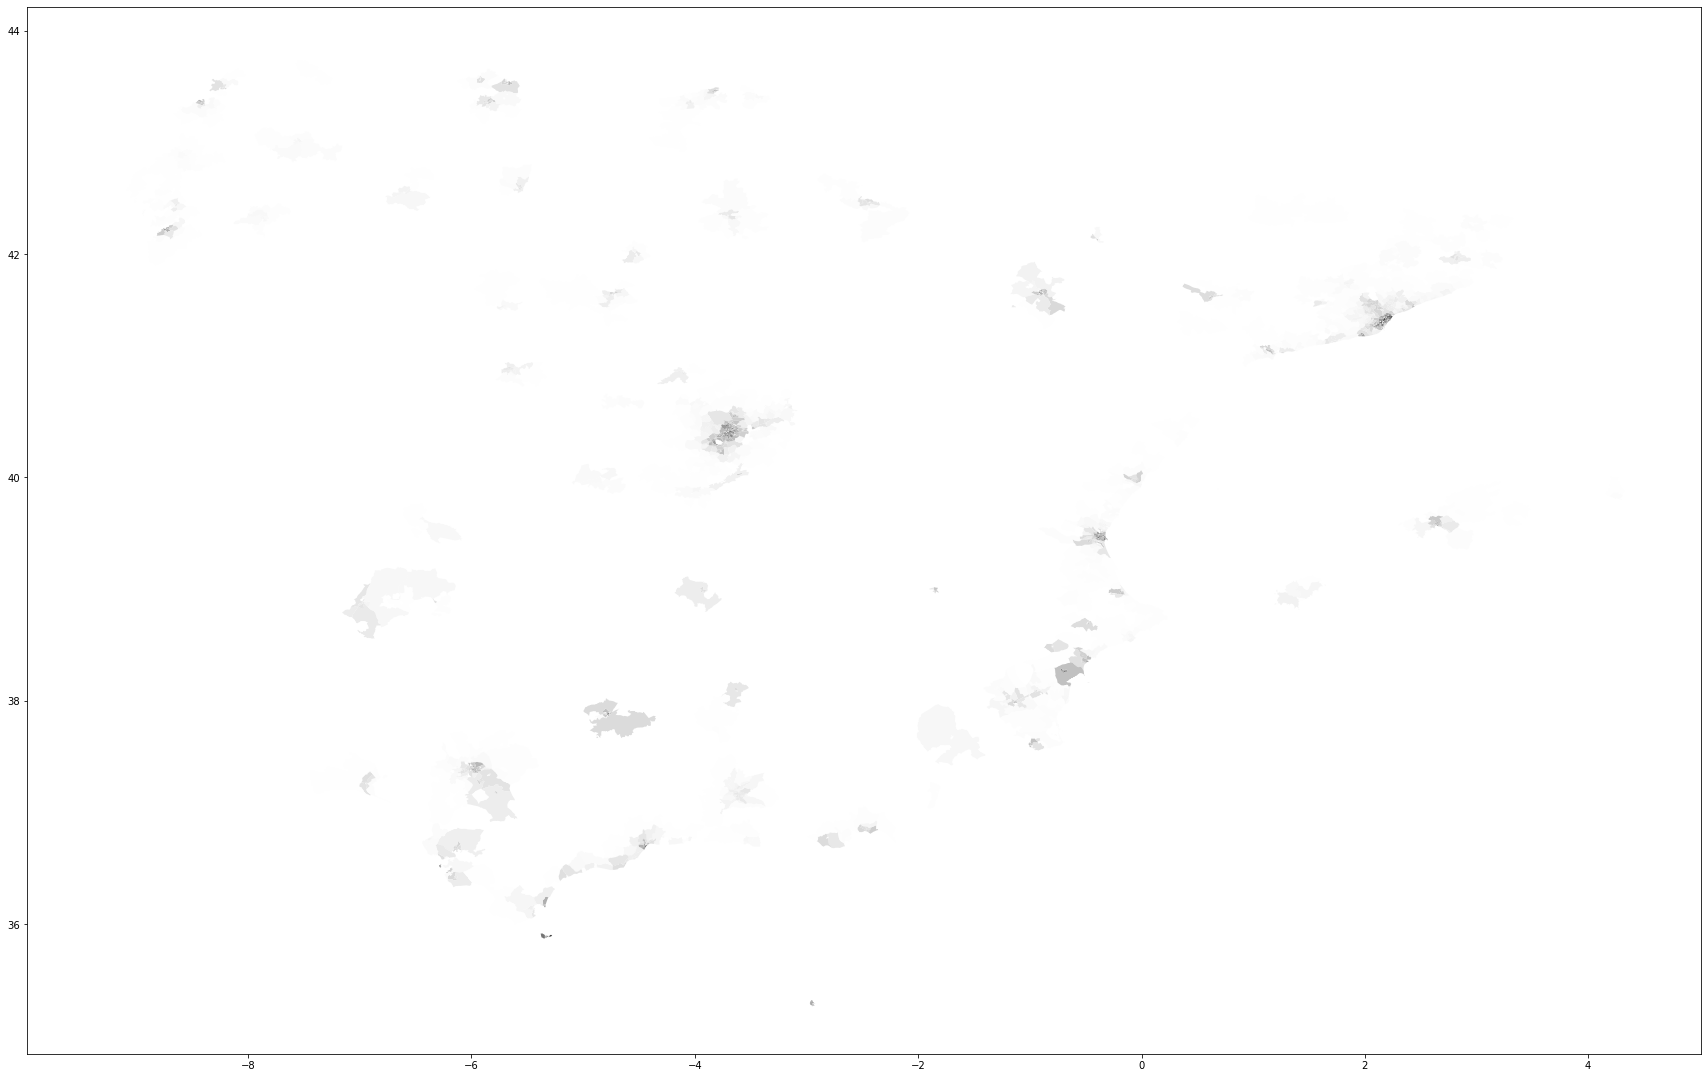

In [47]:
vmin, vmax = 0, 800

fig, ax = plt.subplots(1, figsize=(30, 20))

young_per_km2_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### middle_per_km2_lag

In [48]:
middle_per_km2_lag1 = pd.DataFrame(middle_per_km2_lag)
middle_per_km2_lag1 = middle_per_km2_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
middle_per_km2_lag1 = gpd.GeoDataFrame(middle_per_km2_lag1, crs="EPSG:4326", geometry='geometry')
middle_per_km2_lag1

,0,geometry
0,68.863829,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,50.776721,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,170.389794,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,9.863729,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,502.060415,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,59.319472,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,7.589085,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,8.096619,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,17.092211,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


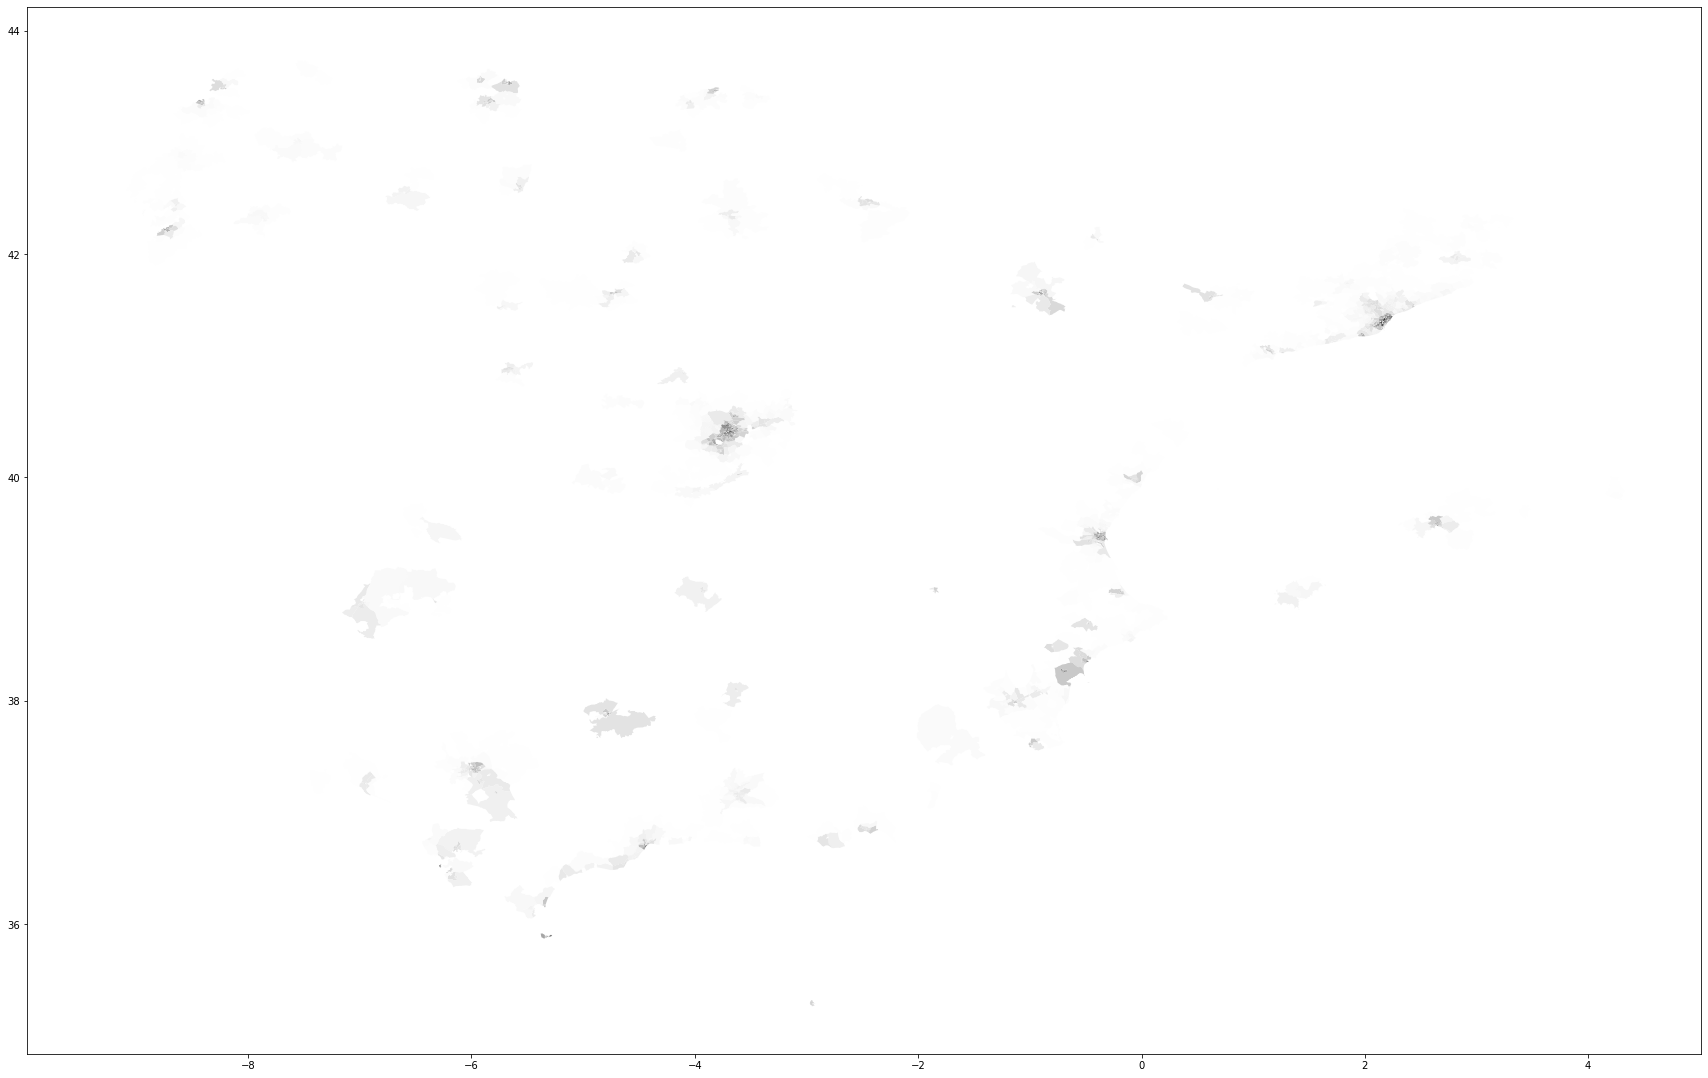

In [49]:
vmin, vmax = 0, 4000

fig, ax = plt.subplots(1, figsize=(30, 20))

middle_per_km2_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### old_per_km2_lag

In [50]:
old_per_km2_lag1 = pd.DataFrame(old_per_km2_lag)
old_per_km2_lag1 = old_per_km2_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
old_per_km2_lag1 = gpd.GeoDataFrame(old_per_km2_lag1, crs="EPSG:4326", geometry='geometry')
old_per_km2_lag1

,0,geometry
0,18.055824,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,9.051079,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,48.901862,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,3.518146,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,99.827321,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,5.721143,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,3.160051,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,3.273509,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,5.584326,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


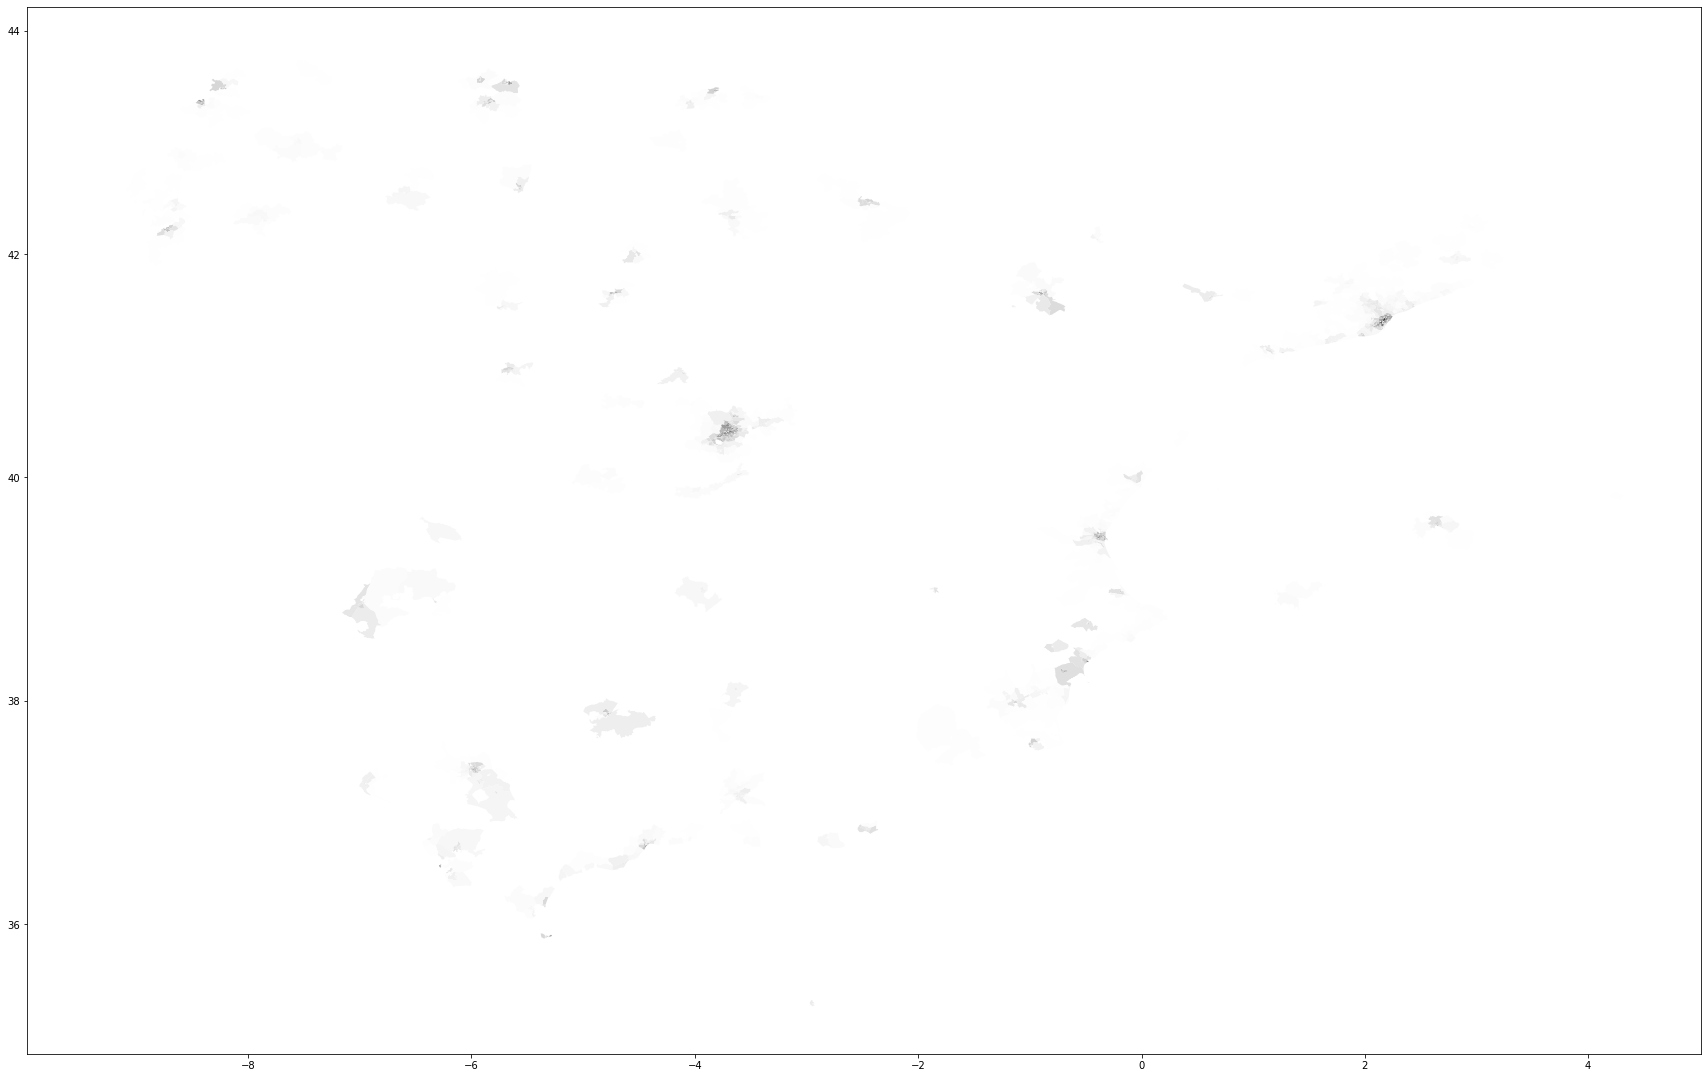

In [51]:
vmin, vmax = 0, 1000

fig, ax = plt.subplots(1, figsize=(30, 20))

old_per_km2_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### less45m2_per_km2_lag

In [52]:
less45m2_per_km2_lag1 = pd.DataFrame(less45m2_per_km2_lag)
less45m2_per_km2_lag1 = less45m2_per_km2_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
less45m2_per_km2_lag1 = gpd.GeoDataFrame(less45m2_per_km2_lag1, crs="EPSG:4326", geometry='geometry')
less45m2_per_km2_lag1

,0,geometry
0,0.151735,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,0.153545,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,0.625001,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,0.022772,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,2.161939,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,0.371901,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,0.007114,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,0.017716,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,0.336106,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


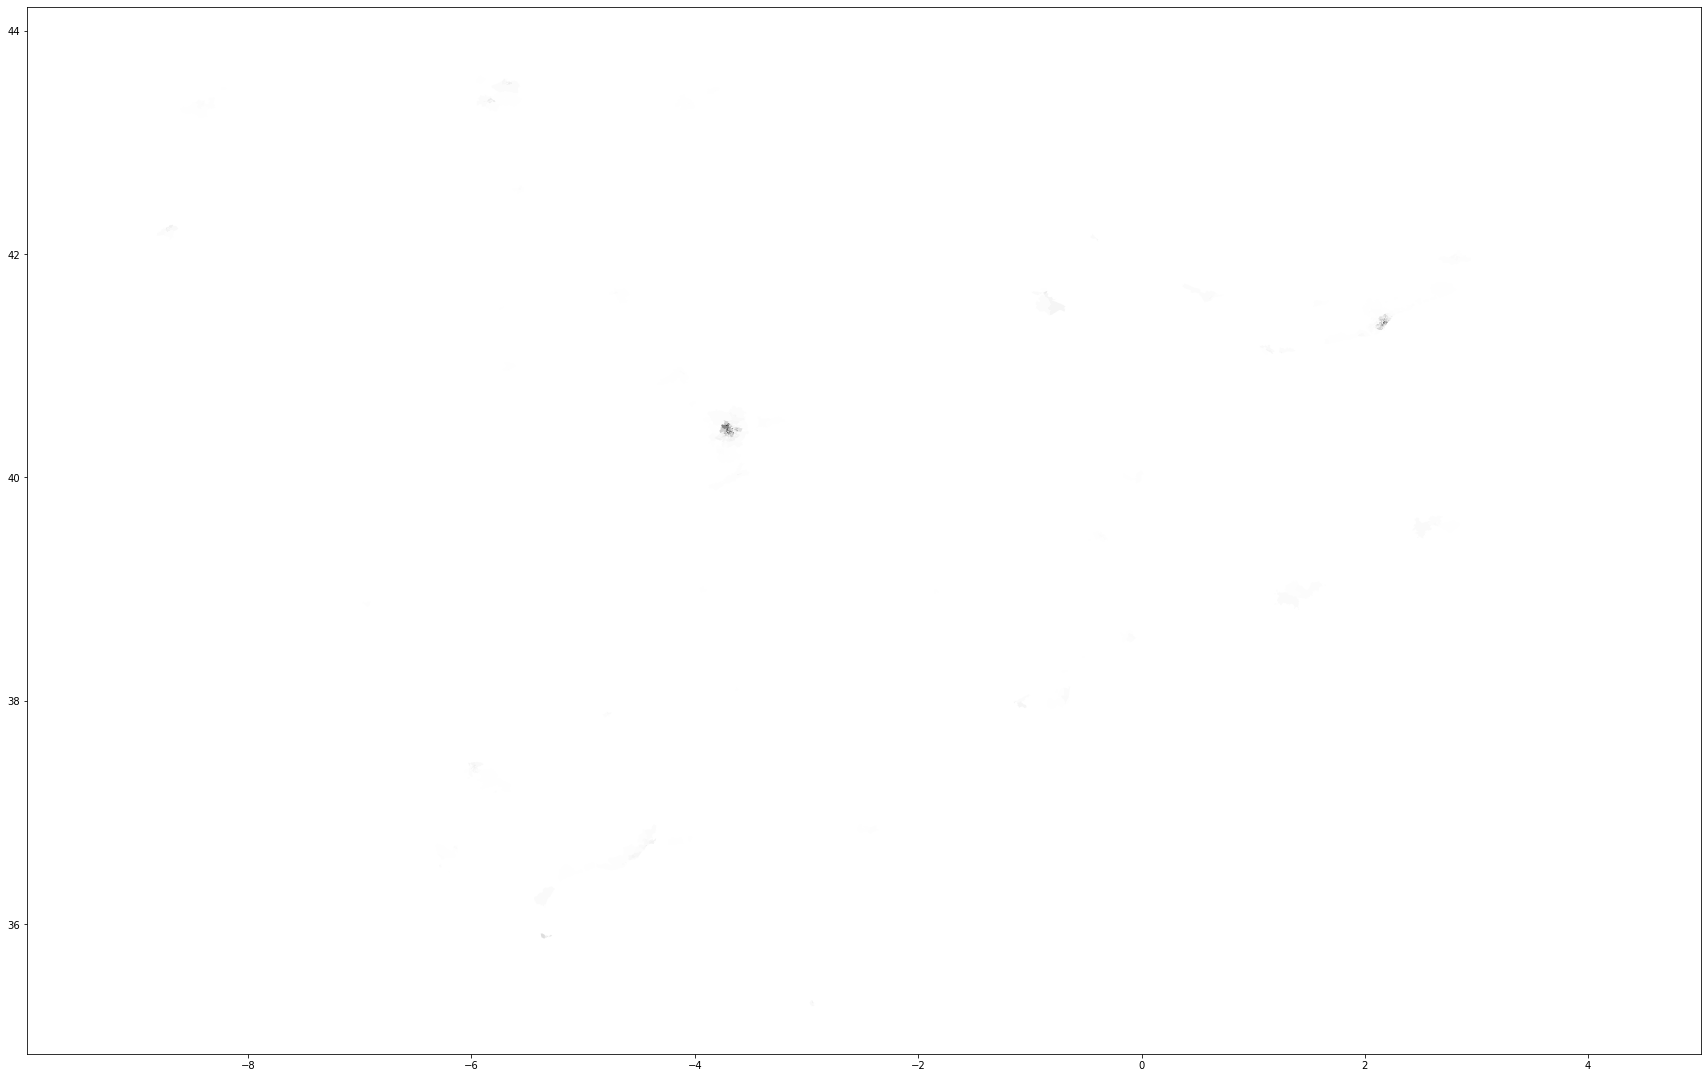

In [53]:
vmin, vmax = 0, 40

fig, ax = plt.subplots(1, figsize=(30, 20))

less45m2_per_km2_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### med_small_per_km2_lag

In [54]:
med_small_per_km2_lag1 = pd.DataFrame(med_small_per_km2_lag)
med_small_per_km2_lag1 = med_small_per_km2_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
med_small_per_km2_lag1 = gpd.GeoDataFrame(med_small_per_km2_lag1, crs="EPSG:4326", geometry='geometry')
med_small_per_km2_lag1

,0,geometry
0,0.837284,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,0.496147,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,5.547720,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,0.103536,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,20.805109,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,1.892616,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,0.146437,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,0.168188,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,0.768788,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


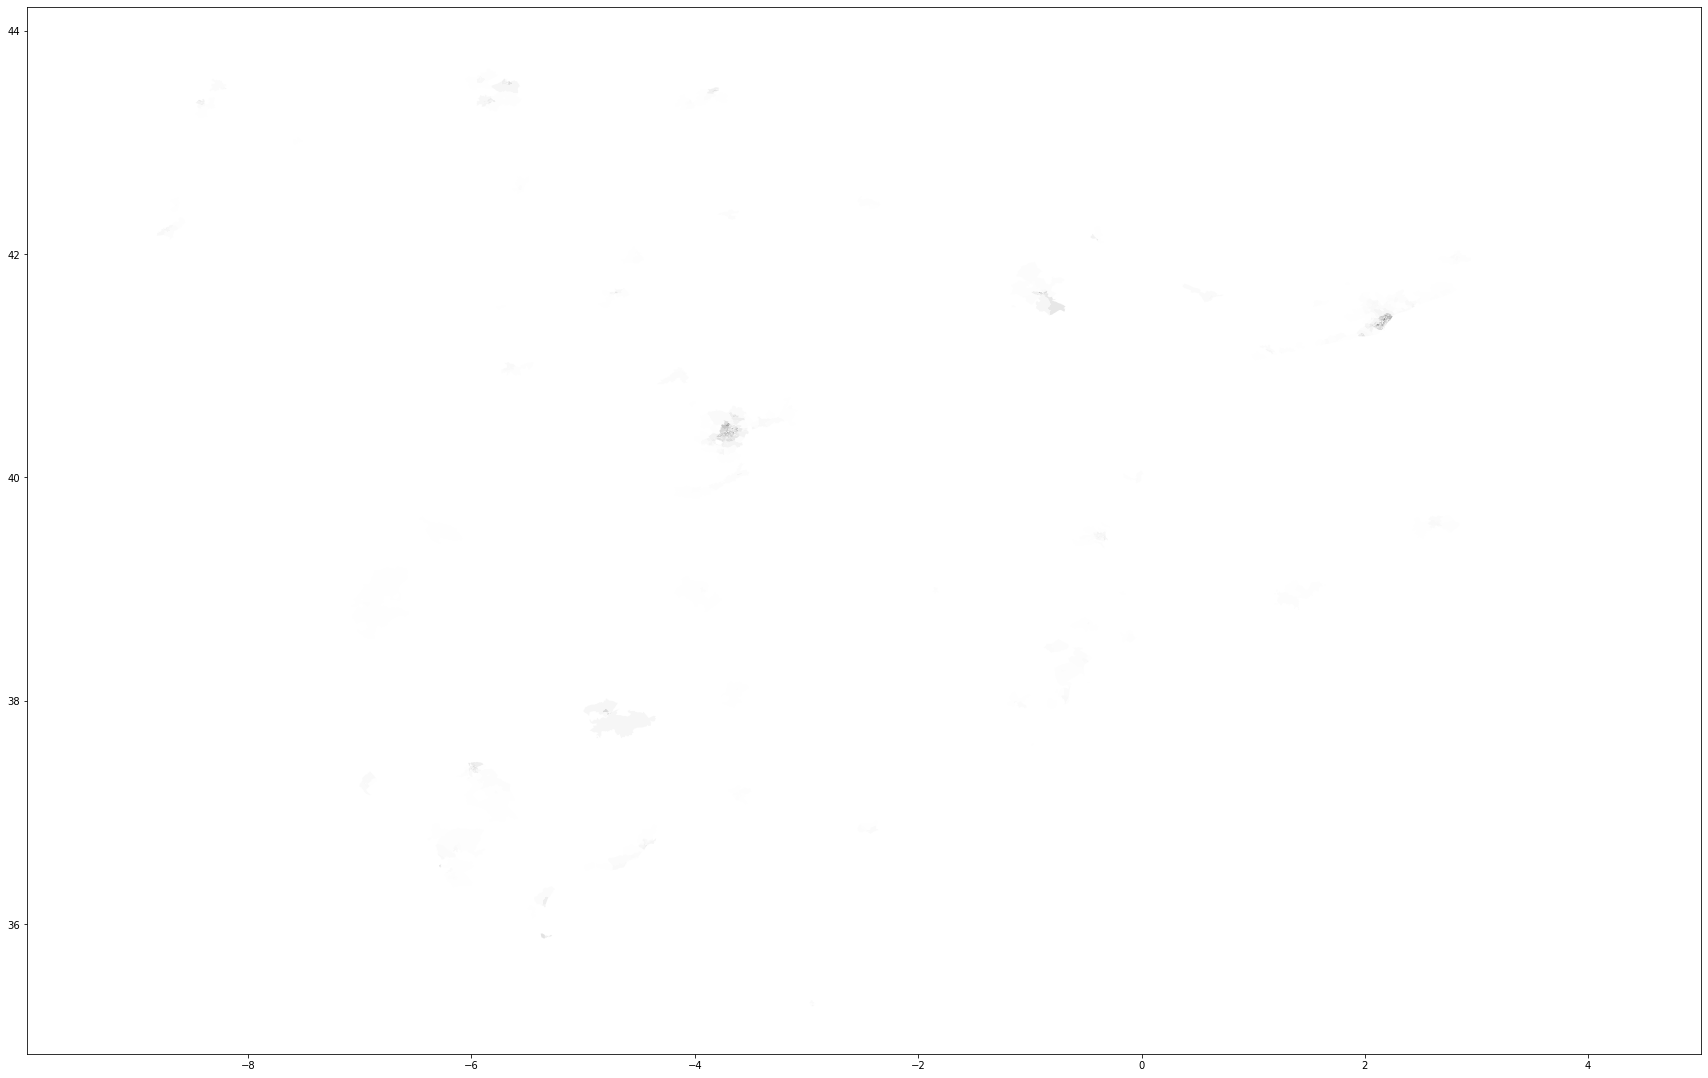

In [55]:
vmin, vmax = 0, 100

fig, ax = plt.subplots(1, figsize=(30, 20))

med_small_per_km2_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### large_med_per_km2_lag

In [56]:
large_med_per_km2_lag1 = pd.DataFrame(large_med_per_km2_lag)
large_med_per_km2_lag1 = large_med_per_km2_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
large_med_per_km2_lag1 = gpd.GeoDataFrame(large_med_per_km2_lag1, crs="EPSG:4326", geometry='geometry')
large_med_per_km2_lag1

,0,geometry
0,13.074182,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,9.962057,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,35.730486,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,1.729615,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,149.579808,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,23.763248,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,1.784443,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,2.743346,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,3.746317,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


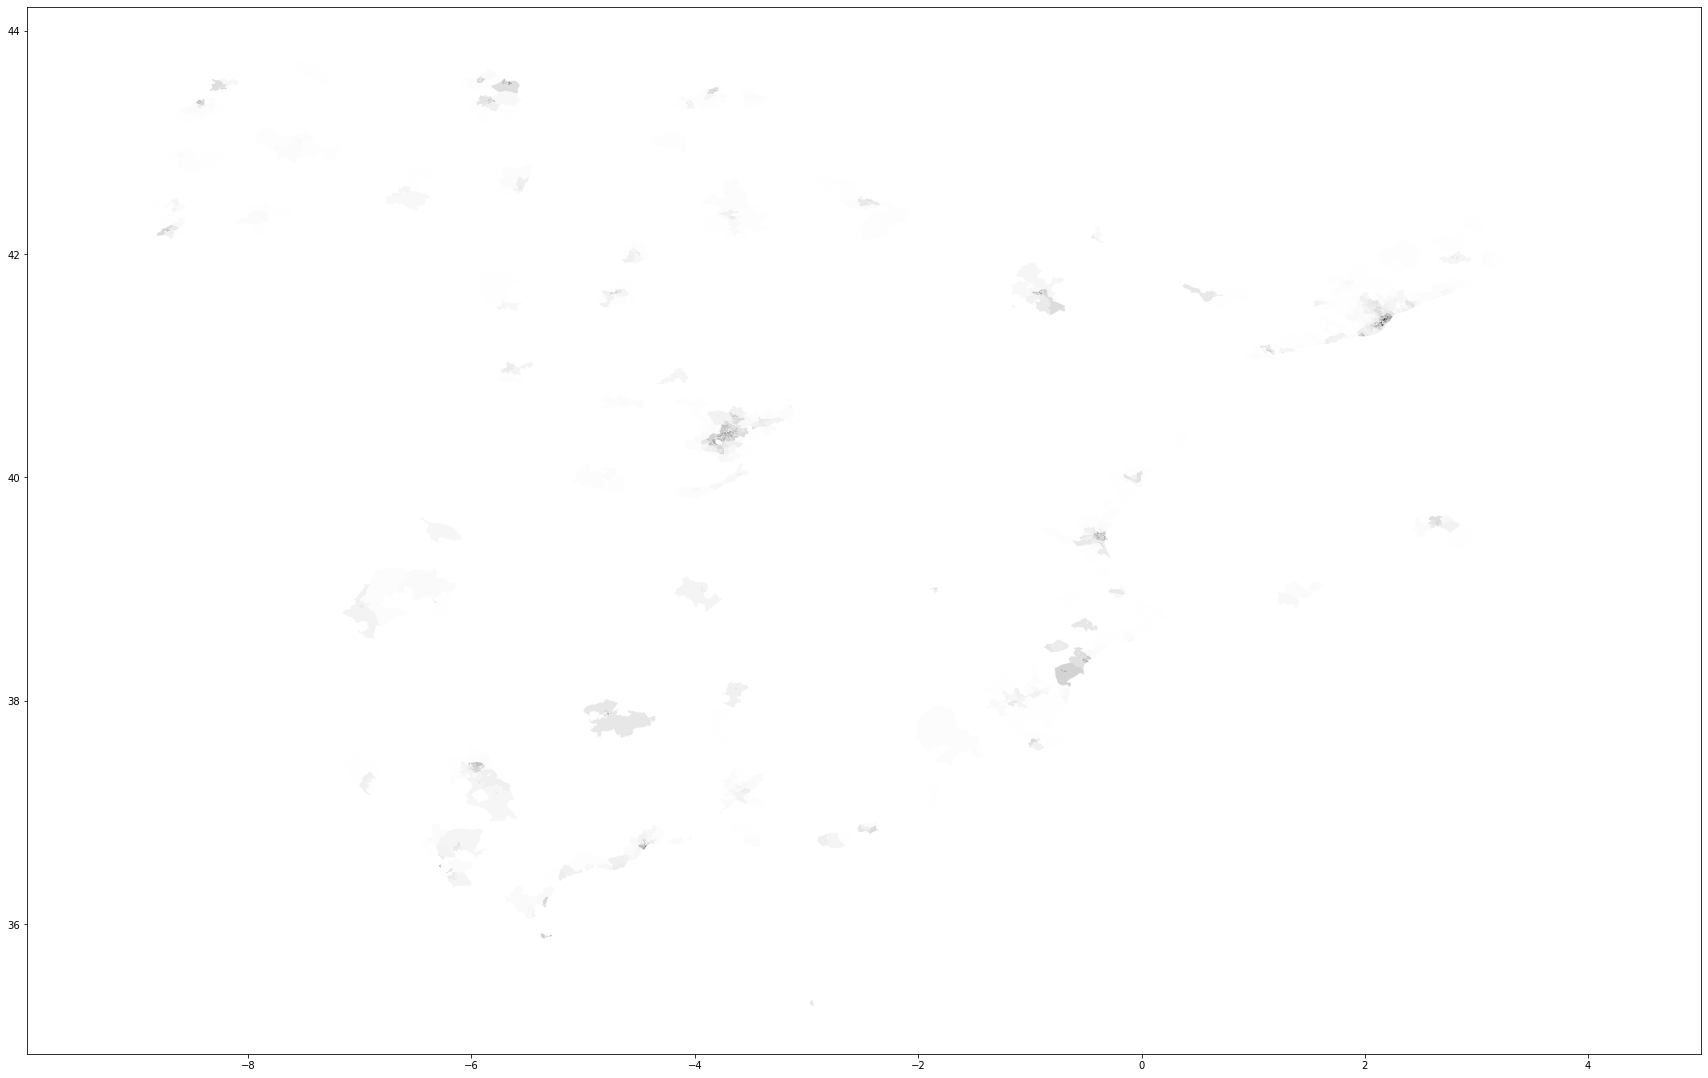

In [57]:
vmin, vmax = 0, 400

fig, ax = plt.subplots(1, figsize=(30, 20))

large_med_per_km2_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

#### more90m2_per_km2_lag

In [58]:
more90m2_per_km2_lag1= pd.DataFrame(more90m2_per_km2_lag)
more90m2_per_km2_lag1 = more90m2_per_km2_lag1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
more90m2_per_km2_lag1 = gpd.GeoDataFrame(more90m2_per_km2_lag1, crs="EPSG:4326", geometry='geometry')
more90m2_per_km2_lag1

,0,geometry
0,20.960332,"POLYGON ((-1.05858 38.34556, -1.05858 38.34556..."
1,8.316135,"POLYGON ((-1.19809 38.28787, -1.20045 38.28562..."
2,30.383393,"POLYGON ((-8.27051 43.28381, -8.27050 43.27841..."
3,3.209079,"POLYGON ((-4.49641 38.99369, -4.48571 38.98113..."
4,80.842247,"POLYGON ((1.93249 41.53670, 1.93238 41.53643, ..."
...,...,...
2564,7.800086,"POLYGON ((-1.20946 41.62127, -1.20885 41.62033..."
2565,2.464663,"POLYGON ((-4.51528 41.39409, -4.49249 41.37419..."
2566,1.469132,"POLYGON ((-1.83997 41.87748, -1.84044 41.87612..."
2567,4.609027,"POLYGON ((-3.34830 36.88873, -3.34839 36.88855..."


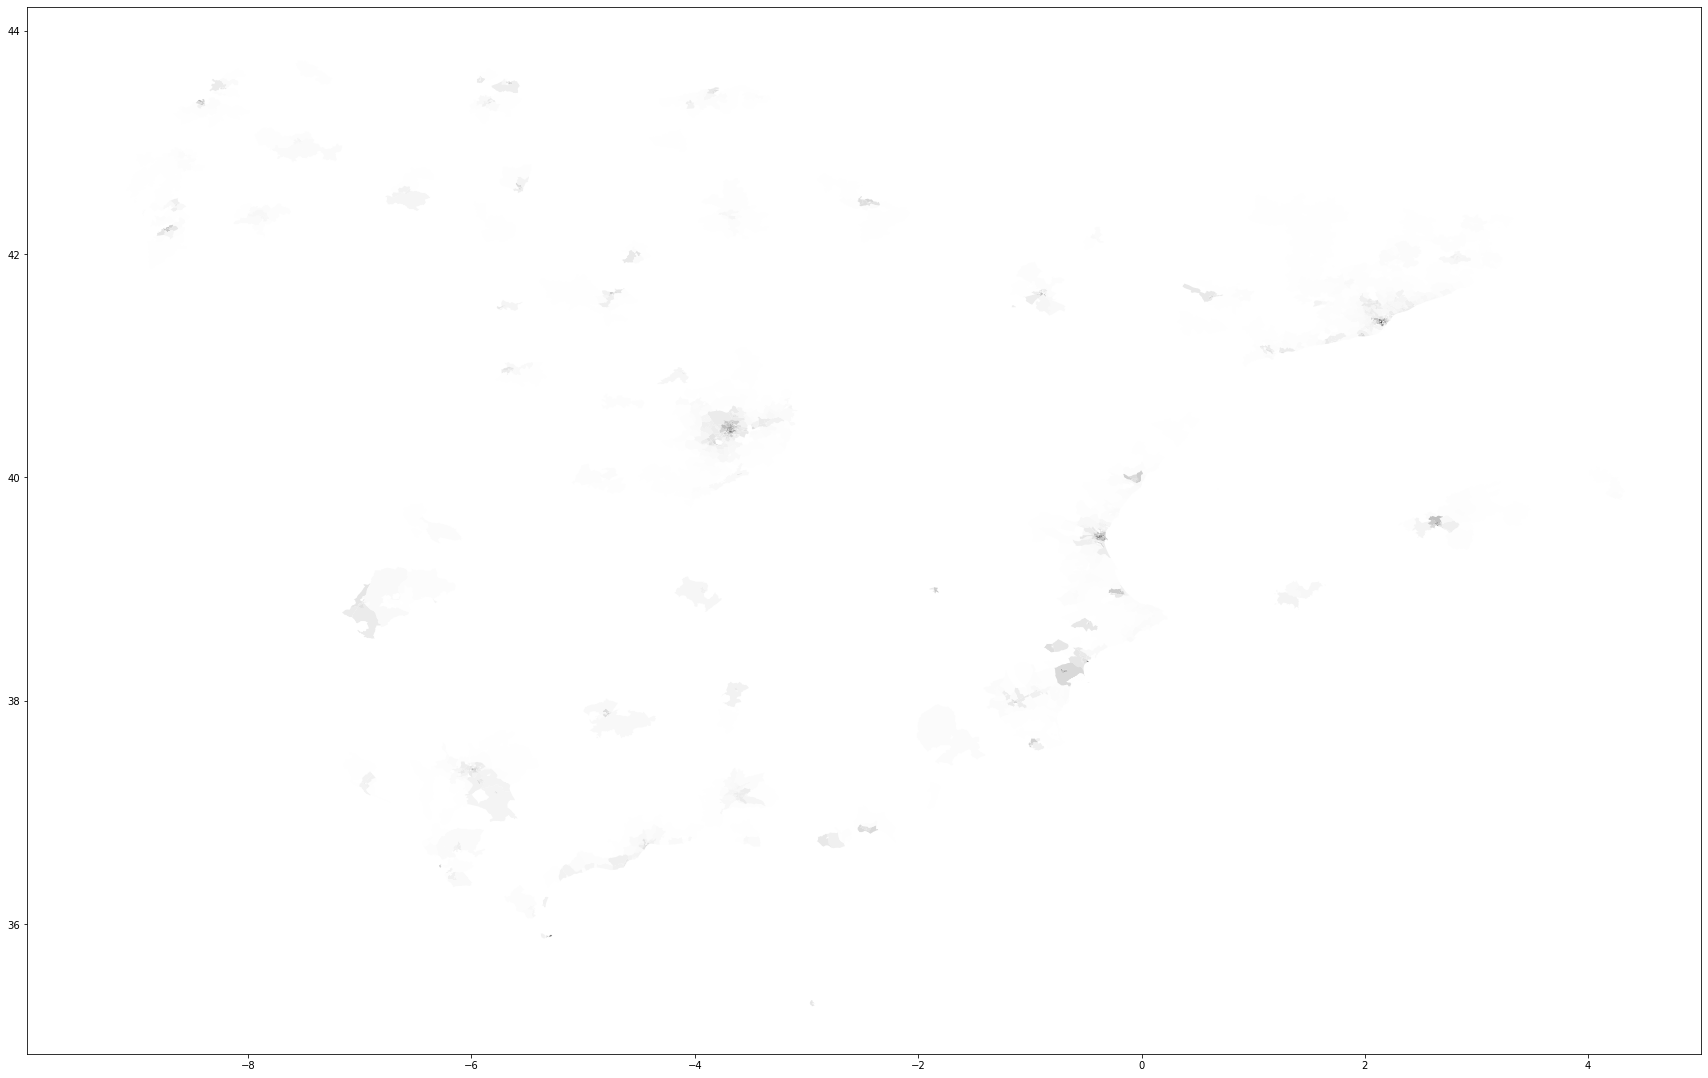

In [59]:
vmin, vmax = 0, 6

fig, ax = plt.subplots(1, figsize=(30, 20))

more90m2_per_km2_lag1.plot(column=0, cmap='gist_yarg', linewidth=0.8,ax = ax)

### Random forrest no2 on lagged features

In [101]:
resall =pd.DataFrame()
res_w1 =pd.DataFrame()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

seed=7

kfold=KFold(n_splits=10, random_state=seed, shuffle = True)

num_trees=100
num_features=5
max_depth = 5
model=RandomForestRegressor(n_estimators=num_trees, max_features=num_features,max_depth=max_depth, random_state=seed)
model.fit(lag_matrix,Y)

results_NO2_avg=cross_val_score(model, lag_matrix, Y, cv=kfold)

print(f'Random Forest - Accuracy {results_NO2_avg.mean()*100:.3f}% std {results_NO2_avg.std()*100:3f}%')

res_w1["Res"]=results_NO2_avg
res_w1["Type"]="Random Forest"

resall=pd.concat([resall,res_w1], ignore_index=True)

Random Forest - Accuracy 84.102% std 2.821056%


income_lag       0.0148
pob_sale_lag     0.0283
travel_perc_lag  0.0183
tot_build_perc_lag  0.0423
housing_perc_lag  0.0141
young_per_km2_lag  0.2625
middle_per_km2_lag  0.1352
old_per_km2_lag  0.0152
less45m2_per_km2_lag  0.0484
med_small_per_km2_lag  0.2834
large_med_per_km2_lag  0.1126
more90m2_per_km2_lag  0.0250


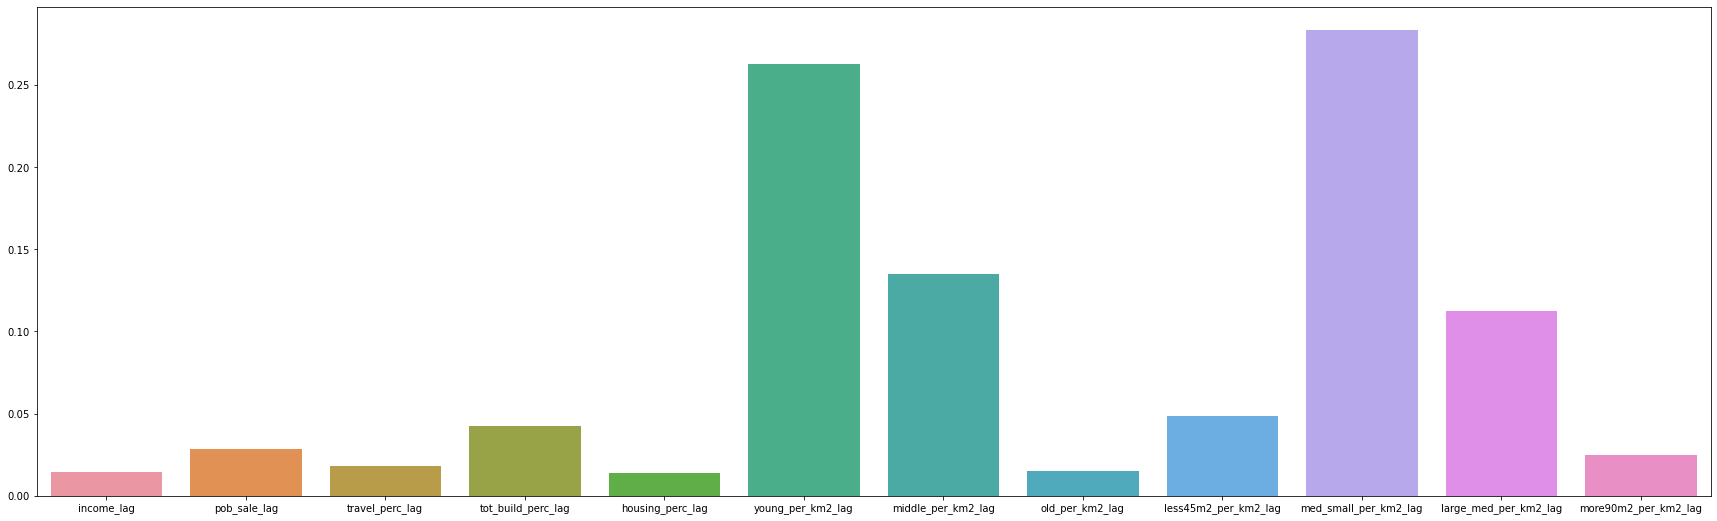

In [102]:
plt.figure(figsize=(30,9))

for name, importance in zip(names, model.feature_importances_):
    print(f'{name:15s}  {importance:.4f}')

sns.barplot(x=names, y=model.feature_importances_)

### Map accuracy

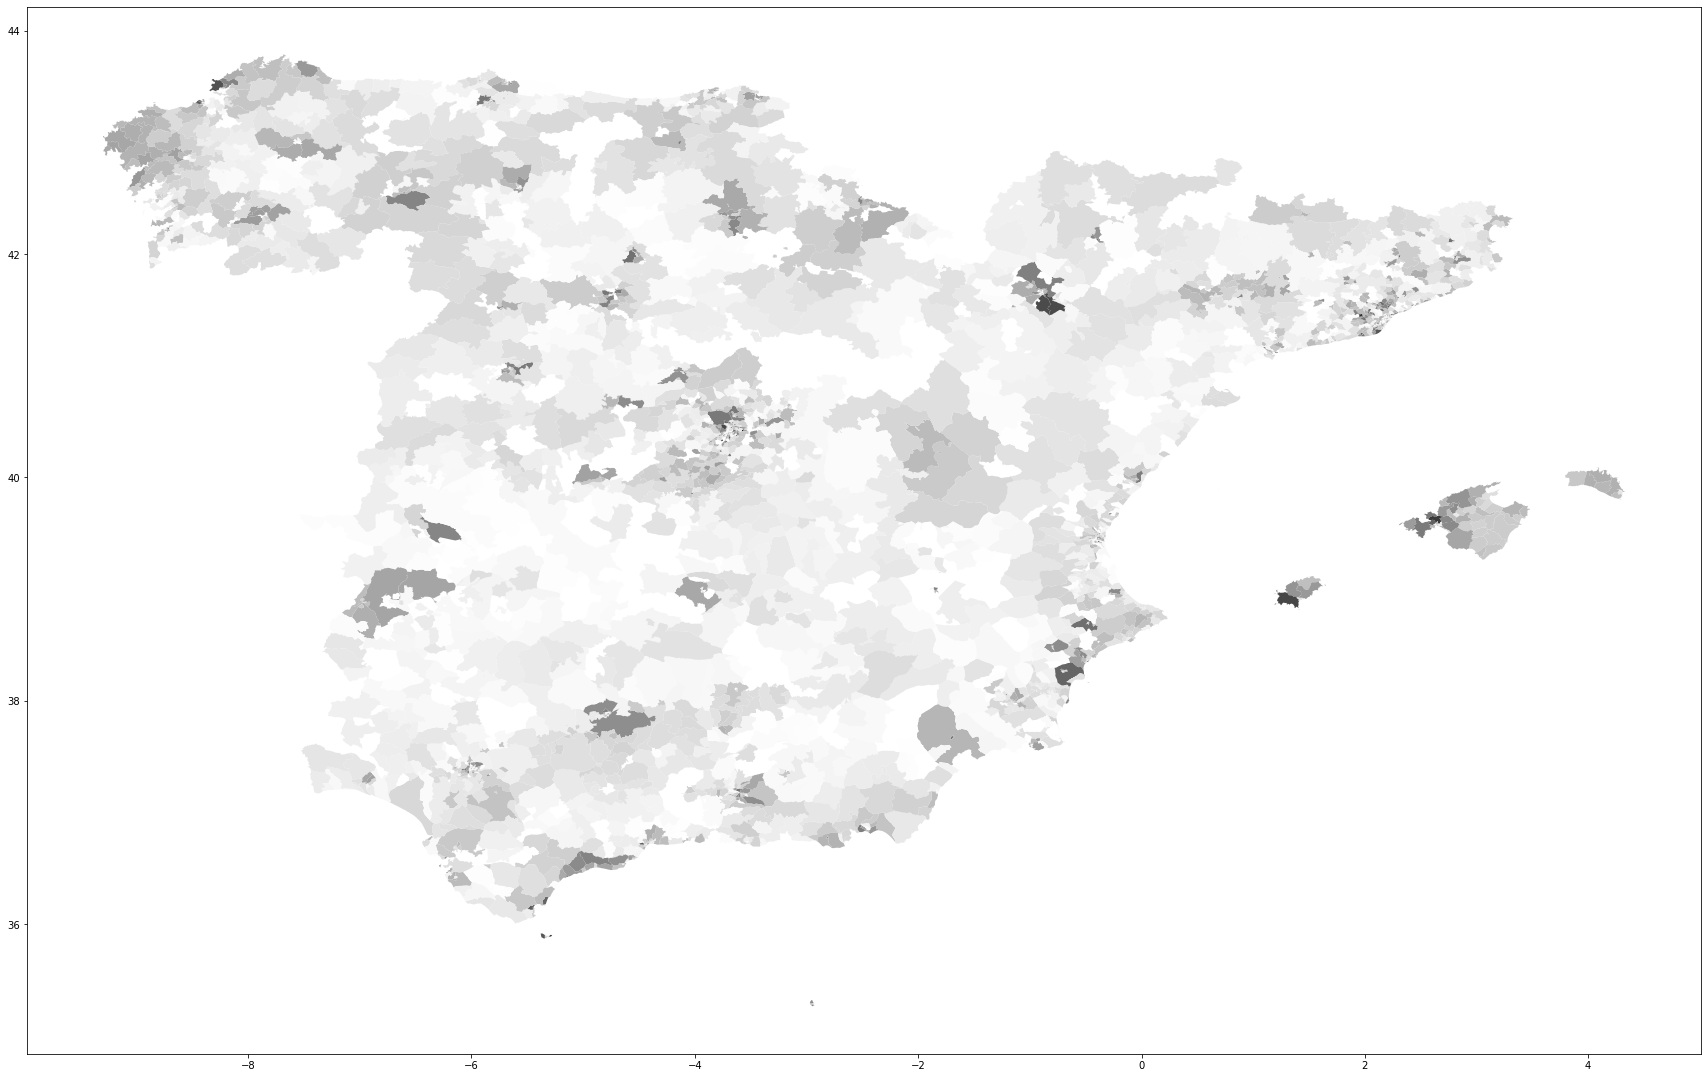

In [103]:
pred = model.predict(lag_matrix)

abs_diff =  abs(pred - Y)
abs_diff = pd.DataFrame(abs_diff)

abs_diff = abs_diff.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)

abs_diff = gpd.GeoDataFrame(abs_diff, crs="EPSG:4326", geometry='geometry')

vmin, vmax = 0, 3

fig, ax = plt.subplots(1, figsize=(30, 20))

abs_diff.plot(column='NO2_avg', cmap='gist_yarg', linewidth=0.8,ax = ax)

### Random forrest  no2 on mixed features

In [324]:
mix_matrix = np.concatenate(( income_lag,  pob_sale_lag, less45m2_per_km2_lag, med_small_per_km2, large_med_per_km2,more90m2_per_km2,young_per_km2_lag,housing_perc),axis=1)
names= ['income_lag','pob_sale_lag','less45m2_per_km2','med_small_per_km2','large_med_per_km2','more90m2_per_km2','young_per_km2_lag','housing_perc']


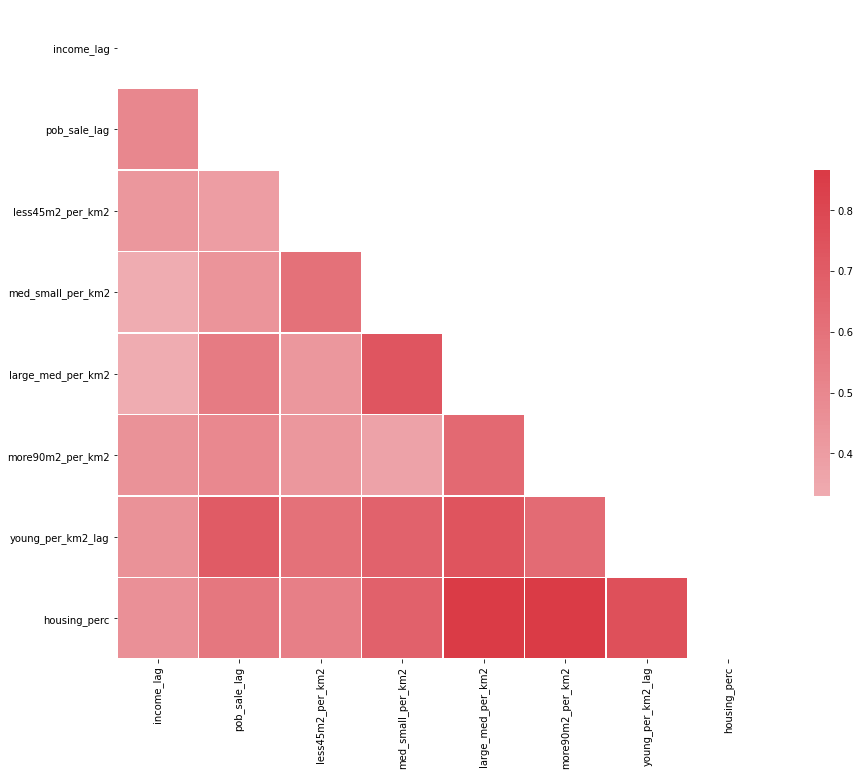

In [325]:
mix_matrix1= pd.DataFrame(mix_matrix)
mix_matrix1.columns = names
f, ax = plt.subplots(figsize=(16, 12))

mask = np.zeros_like(mix_matrix1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(mix_matrix1.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [391]:
resall =pd.DataFrame()
res_w1 =pd.DataFrame()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

seed=7

kfold=KFold(n_splits=10, random_state=seed, shuffle = True)

num_trees=100
num_features=5
max_depth = 5
model1=RandomForestRegressor(n_estimators=num_trees, max_features=num_features,max_depth=max_depth, random_state=seed)
model1.fit(mix_matrix,Y)

results_NO2_avg=cross_val_score(model1, mix_matrix, Y, cv=kfold)

print(f'Random Forest - Accuracy {results_NO2_avg.mean()*100:.3f}% std {results_NO2_avg.std()*100:3f}%')

res_w1["Res"]=results_NO2_avg
res_w1["Type"]="Random Forest"

resall=pd.concat([resall,res_w1], ignore_index=True)

Random Forest - Accuracy 88.651% std 0.979779%


In [392]:
mean_NO2_avg = Y.mean()
print(f'Average NO2 level: {mean_NO2_avg}')
print()
print(f'Expected error range: [{mean_NO2_avg-(1-results_NO2_avg.mean()/100)}, {mean_NO2_avg+(1-results_NO2_avg.mean()/100)}]')

Average NO2 level: 12.847696532150087

Expected error range: [11.856561640693192, 13.838831423606981]


income_lag       0.0153
pob_sale_lag     0.0313
less45m2_per_km2  0.0982
med_small_per_km2  0.1295
large_med_per_km2  0.3125
more90m2_per_km2  0.0528
young_per_km2_lag  0.0761
housing_perc     0.2843


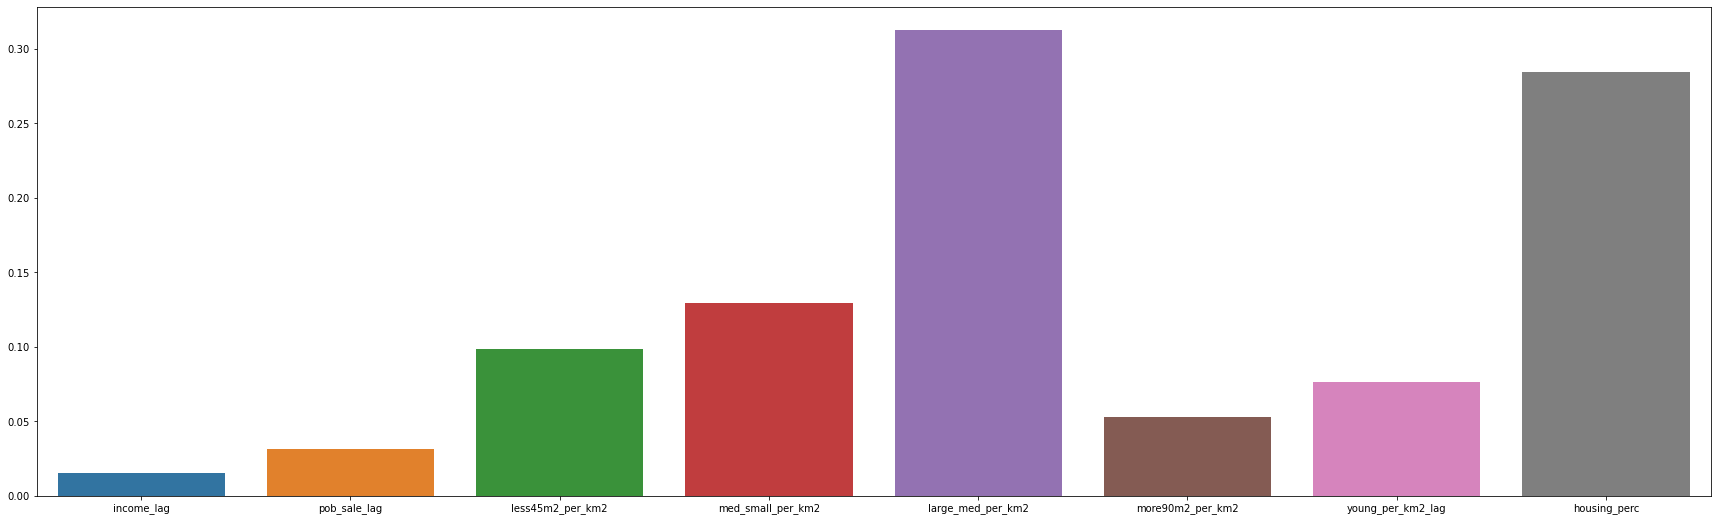

In [393]:
plt.figure(figsize=(30,9))

for name, importance in zip(names, model1.feature_importances_):
    print(f'{name:15s}  {importance:.4f}')

sns.barplot(x=names, y=model1.feature_importances_)

### Map accuracy

In [394]:
pred1 = model1.predict(mix_matrix)

abs_diff1 = abs(Y-pred1)/Y
abs_diff1 = pd.DataFrame(abs_diff1)

abs_diff1 = abs_diff1.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
abs_diff1

abs_diff1 = gpd.GeoDataFrame(abs_diff1, crs="EPSG:4326", geometry='geometry')

vmin, vmax = 0, 0.5
#fig, ax = plt.subplots(1, figsize=(30, 20))

#abs_diff1.plot(column='NO2_avg', cmap='gist_yarg', linewidth=0.8,ax = ax)

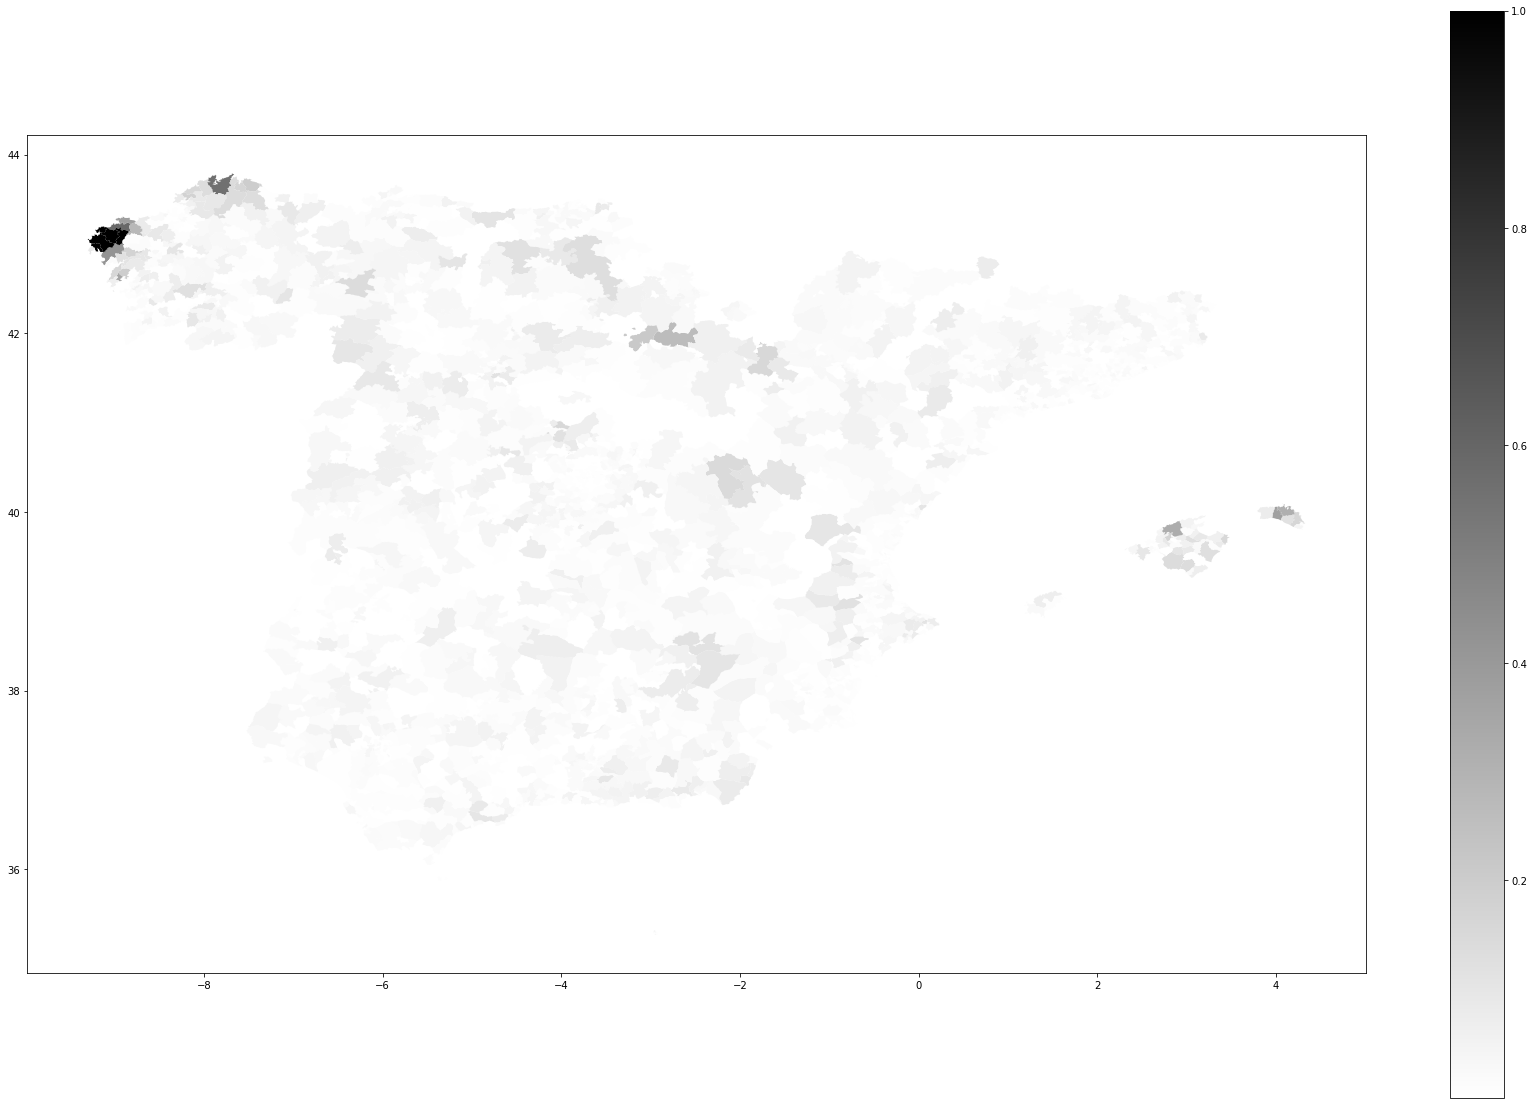

In [395]:
abs_diff1.NO2_avg = np.clip(abs_diff2.NO2_avg, 0, 1)
fig, ax = plt.subplots(1, figsize=(30, 20))
abs_diff1.plot(column='NO2_avg', cmap='gist_yarg', linewidth=0.8,ax = ax, legend=True)

In [420]:
mix_matrix = np.concatenate(( income_lag,  pob_sale_lag, less45m2_per_km2_lag, med_small_per_km2, large_med_per_km2,more90m2_per_km2,young_per_km2_lag,housing_perc),axis=1)
names= ['income_lag','pob_sale_lag','less45m2_per_km2_lag','med_small_per_km2','large_med_per_km2','more90m2_per_km2','young_per_km2_lag','housing_perc']

In [421]:
import xgboost as xgb


In [422]:
resall =pd.DataFrame()
res_w1 =pd.DataFrame()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

seed=7

kfold=KFold(n_splits=10, random_state=seed, shuffle = True)

num_trees=100
num_features=5
max_depth = 5
model12=xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 
model12.fit(mix_matrix,Y)

results_NO2_avg=cross_val_score(model12, mix_matrix, Y, cv=kfold)

print(f'Random Forest - Accuracy {results_NO2_avg.mean()*100:.3f}% std {results_NO2_avg.std()*100:3f}%')

res_w1["Res"]=results_NO2_avg
res_w1["Type"]="Random Forest"

resall=pd.concat([resall,res_w1], ignore_index=True)

Random Forest - Accuracy 88.876% std 1.376834%


income_lag       0.0429
pob_sale_lag     0.0842
less45m2_per_km2  0.0765
med_small_per_km2  0.1632
large_med_per_km2  0.2218
more90m2_per_km2  0.0553
young_per_km2_lag  0.1494
housing_perc     0.2067


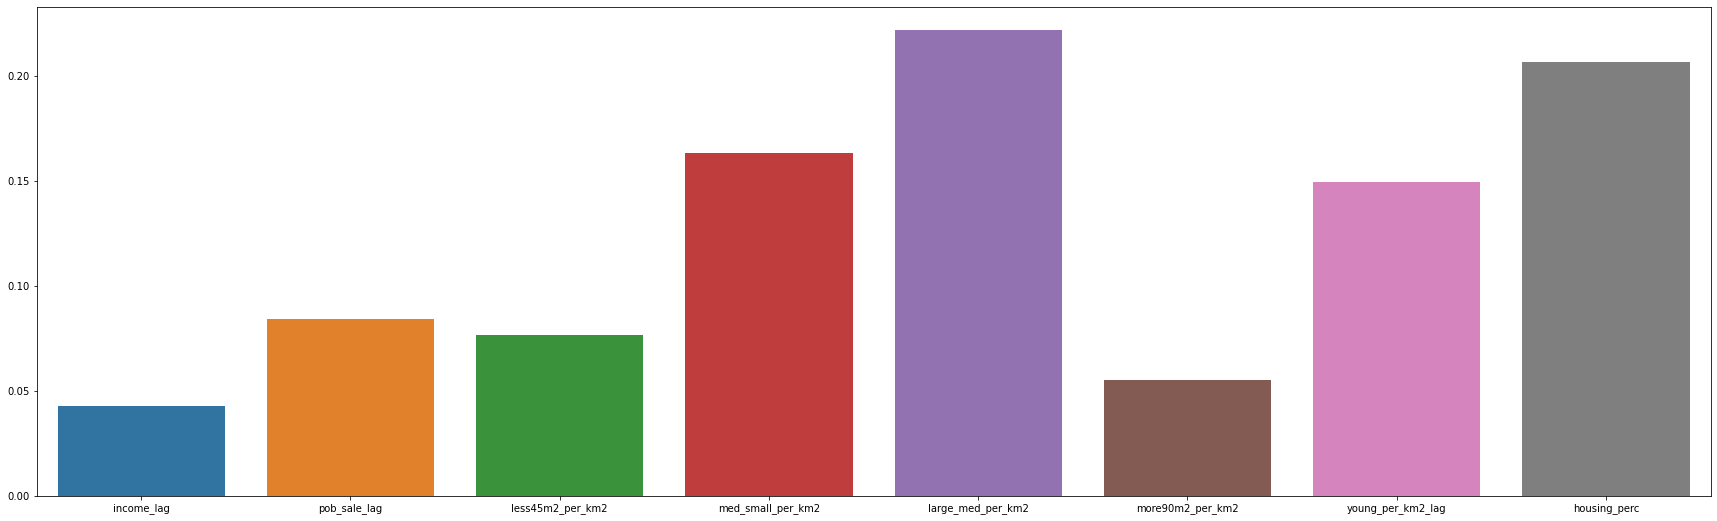

In [423]:
plt.figure(figsize=(30,9))

for name, importance in zip(names, model12.feature_importances_):
    print(f'{name:15s}  {importance:.4f}')

sns.barplot(x=names, y=model12.feature_importances_)

In [424]:
pred2 = model12.predict(mix_matrix)

abs_diff2 = abs(Y-pred2)/Y
abs_diff2 = pd.DataFrame(abs_diff2)

abs_diff2 = abs_diff2.merge(df_tryout.geometry, how = 'left', left_index = True, right_index = True)
abs_diff2

abs_diff2 = gpd.GeoDataFrame(abs_diff2, crs="EPSG:4326", geometry='geometry')

#vmin, vmax = 0, 1
#ig, ax = plt.subplots(1, figsize=(30, 20),vmin =0, vmax =  1)

#abs_diff2.plot(column='NO2_avg', cmap='gist_yarg', linewidth=0.8,ax = ax, legend=True)

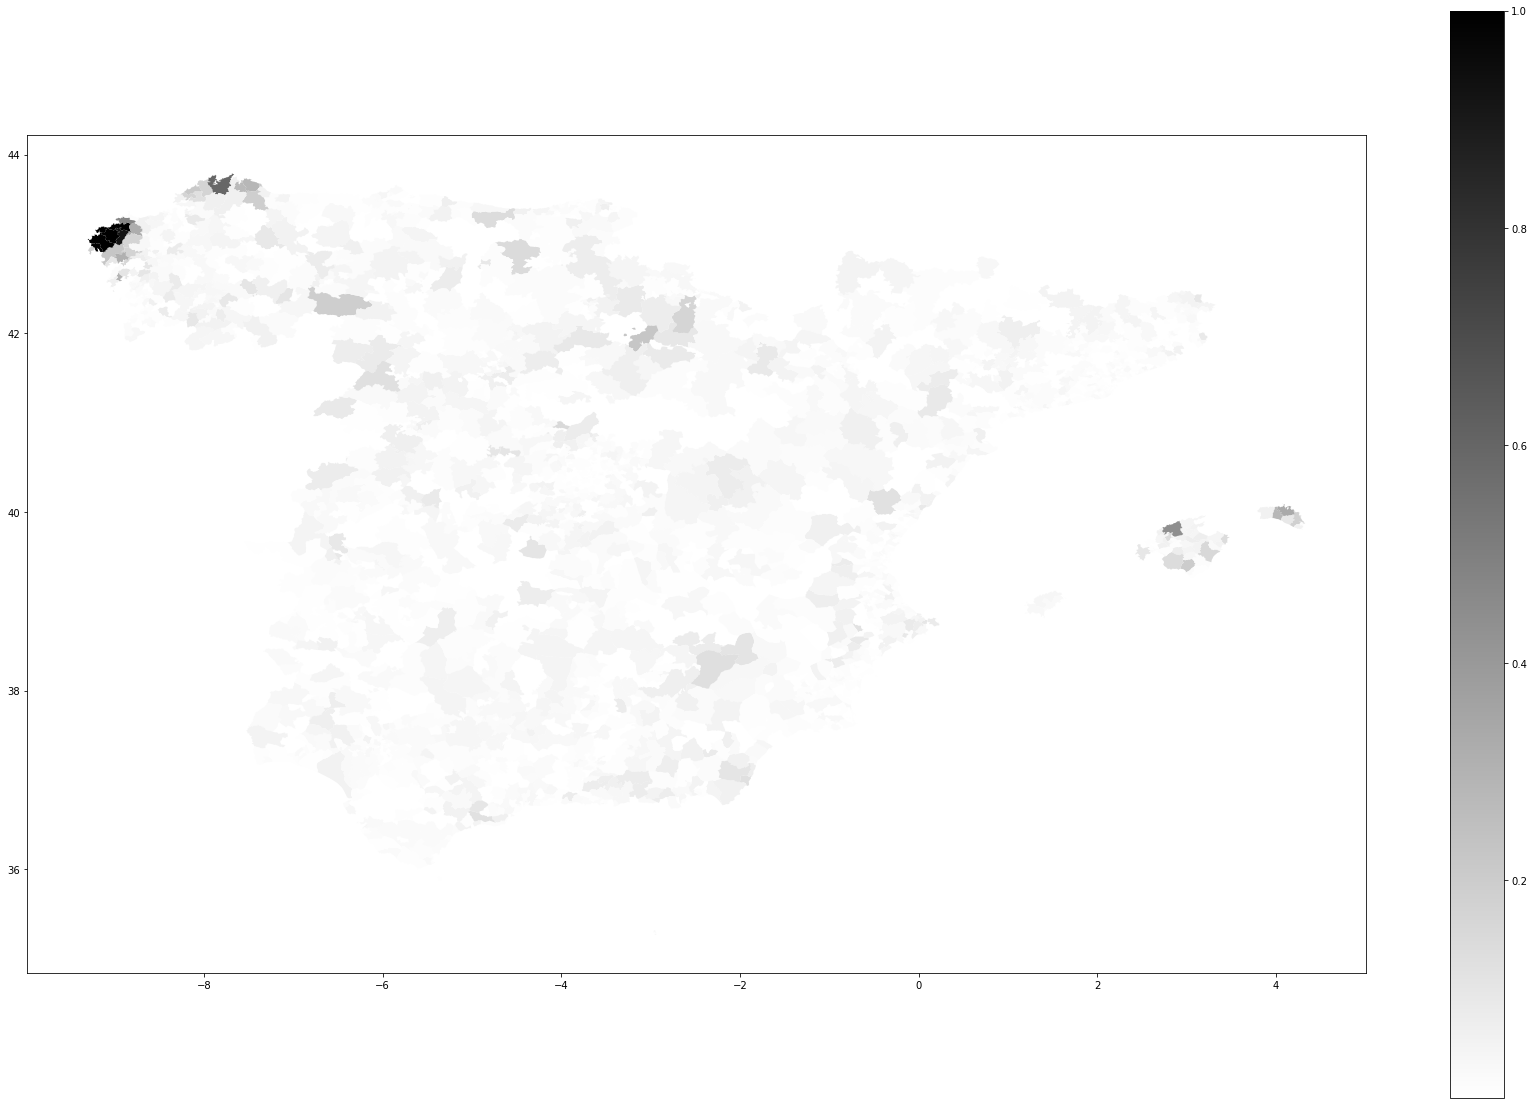

In [413]:
abs_diff2.NO2_avg = np.clip(abs_diff2.NO2_avg, 0, 1)
fig, ax = plt.subplots(1, figsize=(30, 20))
abs_diff2.plot(column='NO2_avg', cmap='gist_yarg', linewidth=0.8,ax = ax, legend=True)